In [1]:
%run '08222019_functions.ipynb'
%run imports.ipynb

In [2]:
calldata_out= zarr.open('data/outgroup_alleles_phase2.zarr/')
calldata_biallel= zarr.open('data/phase2_biallel_allele_count.zarr/')

In [3]:
an_col = 'AOcol', 'BFcol', 'GNcol', 'CIcol', 'GHcol'
an_gam = 'GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam', 'UGgam', 'GAgam', 'FRgam'
an_fw = 'GM', 'GW'
out_species = ['arab', 'chri', 'epir', 'mela', 'meru', 'quad']

In [4]:
A = an_gam
B = an_col
C = 'KE'
D = 'chri'

In [5]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

/opt/conda/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [6]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.35.63.174:38029 Dashboard: /user/carlo%20mariade%20marco1/proxy/45377/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
def count_alleles_pos(chrom, start, stop):
    df_samples = pd.read_csv("samples.meta.txt", sep="\t")
    pos_all = allel.SortedIndex(callset_biallel[chrom]["variants/POS"])
    loc = pos_all.locate_range(start,stop)
    gt = allel.GenotypeDaskArray(callset_biallel[chrom]['calldata/GT'])
    subpops = metadata.groupby('population').indices
    ac_subpops = allel.AlleleCountsChunkedTable(gt[loc].count_alleles_subpops(subpops))
    return ac_subpops

In [10]:
ac_3R_24 = count_alleles_pos('3R', 1, 24_000_000)
ac_3R_24

<AlleleCountsChunkedTable shape=(5760020,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=703.1M
   values=builtins.dict>

In [11]:
loc = (allel.SortedIndex(callset_biallel['3R']["variants/POS"])).locate_range(1, 24_000_000)
loc

slice(0, 5760020, None)

In [12]:
ac_out_3R_24 = {pop: calldata_out['3R'][pop][loc] for pop in out_species}

In [13]:
ac_out_3R_24.keys()

dict_keys(['arab', 'chri', 'epir', 'mela', 'meru', 'quad'])

-------------------------------------------------------
## Perform the ABBA-BABA test
Using the old script

In [14]:
chromosomes = ['3R']

In [15]:
ac_cache = dict()

def load_ac(pop):
    if (pop) in ac_cache:
        return ac_cache[pop]
    else:
        if pop in out_species:
            ac = allel.AlleleCountsChunkedArray(ac_out_3R_24[pop])
        else:
            ac = ac_3R_24[pop]
            ac_cache[pop] = ac
        return ac
    
fourpop_cache = dict()

In [20]:
#this is the function that perform the test
def f4_analysis(chrom, A, B, C, D, blen=100000, plot=False, ax=None):
    
    key = (chrom, A, B, C, D, blen)
    if key in fourpop_cache:
        # re-use from cache
        d, d_se, d_z, d_vb, d_vj = fourpop_cache[key]
        
    else:
        # load allele counts
        aca = load_ac(A)
        acb = load_ac(B)
        acc = load_ac(C)
        acd = load_ac(D)

        # run D test
        d, d_se, d_z, d_vb, d_vj = allel.blockwise_patterson_d(aca, acb, acc, acd, blen=blen)
        
        # cache for re-use
        fourpop_cache[key] = d, d_se, d_z, d_vb, d_vj
    
    return d, d_se, d_z, d_vb, d_vj

#this is the function that allow to perform display multiple tests on a table using d-test cache
def f4_analyses(As, Bs, Cs, Ds, chroms=chromosomes, blen=100000):
    
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
        
    # setup output table
    tbl = [['chromosome', 'test', 'D', 'SE', 'Z']]
    for chrom in chroms:
        for A in As:
            for B in Bs:
                if A != B:
                    for C in Cs:
                        for D in Ds:
                            if C != D:
                                d, d_se, d_z, _, _ = f4_analysis(chrom, A, B, C, D, blen=blen)
                                test = 'D(%s, %s; %s, %s)' % (A, B, C, D)
                                row = [chrom, test, d, d_se, d_z]
                                tbl += [row]
    
    # display results
    (etl
     .wrap(tbl)
     .interpolate('D', '%.3f')
     .interpolate('SE', '%.4f')
     .interpolate('Z', '%.1f')
     .displayall(index_header=False, tr_style=lambda row: 'background-color: %s' % ('#afa' if float(row.Z) > 5 else '#aaf' if float(row.Z) < -5 else 'white')))

def plot_test(chroms, As,Bs,Cs,Ds, blen=100000):
    # normalise inputs
    if not isinstance(chroms, (list, tuple)):
        chroms = [chroms]
    if not isinstance(As, (list, tuple)):
        As = [As]
    if not isinstance(Bs, (list, tuple)):
        Bs = [Bs]
    if not isinstance(Cs, (list, tuple)):
        Cs = [Cs]
    if not isinstance(Ds, (list, tuple)):
        Ds = [Ds]
   
    tbl = []
    tbl2 = [["Block_1","Block_2","Block_3","Block_4","Block_5","Block_6","Block_7","Block_8","Block_9","Block_10","Block_11","Block_12","Block_13","Block_14","Block_15","Block_16","Block_17","Block_18","Block_19","Block_20","Block_21","Block_22","Block_23","Block_24","Block_25","Block_26","Block_27","Block_28","Block_29","Block_30","Block_31","Block_32","Block_33","Block_34","Block_35","Block_36","Block_37","Block_38","Block_39","Block_40","Block_41","Block_42","Block_43","Block_44","Block_45","Block_46","Block_47","Block_48","Block_49","Block_50","Block_51","Block_52","Block_53","Block_54","Block_55","Block_56","Block_57"]]
    tbl3 = [['Test']]

    for chrom in chroms:
        for A in As:
            for B in Bs:
                if A != B:
                    for C in Cs:
                        for D in Ds:
                            if C != D:
                                d, d_se, d_z, b1, _ = f4_analysis(chrom, A, B, C, D, blen=blen)
                                test = "D-Test(%s, %s, %s, %s)" % (A, B, C, D)
                                row = b1
                                tbl += [row]
                                row2 = [test]
                                tbl2 += [row]
                                tbl3 += [row2]
    df1 = etl.todataframe(tbl2)
    df2 = etl.todataframe(tbl3)
    results = df2.join(df1)
    tbl=np.array(tbl)
    
    return results, tbl, plt

In [21]:
results_3R, bloks_3R, plot_3R = plot_test('3R', A,B,C,D, blen = 100000)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


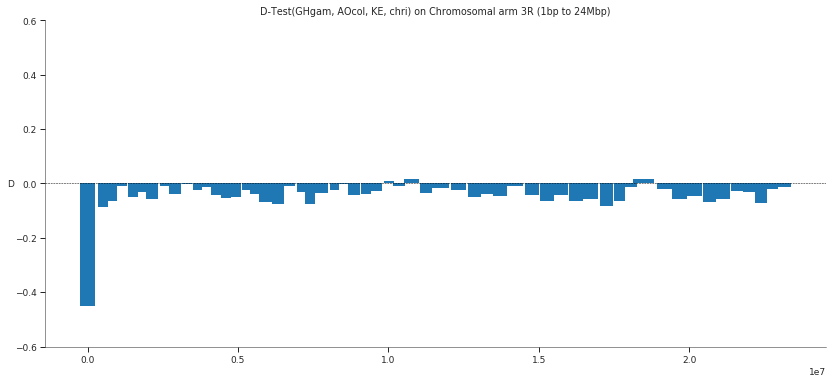

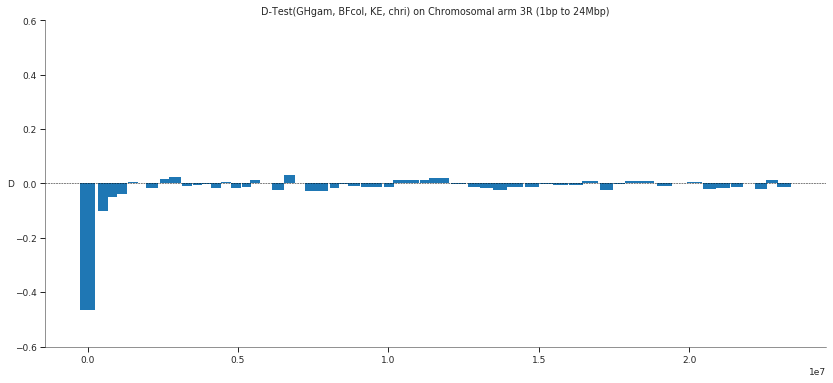

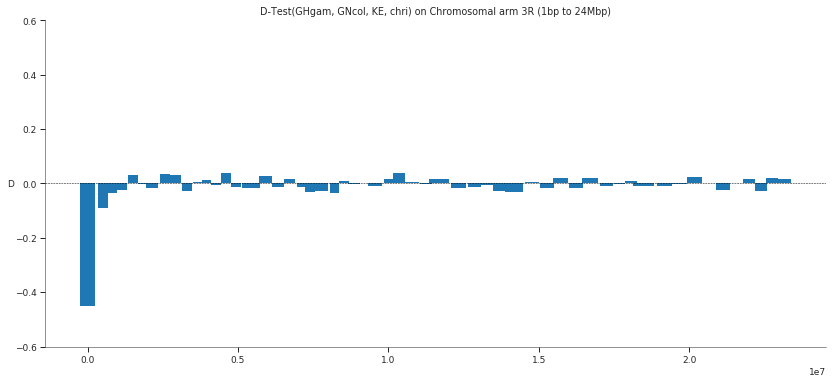

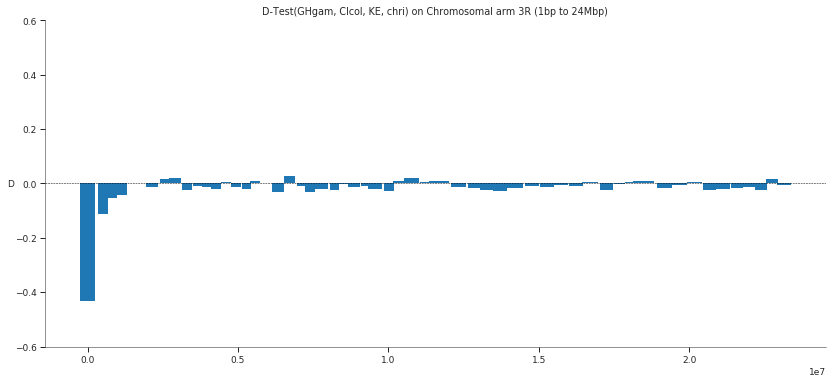

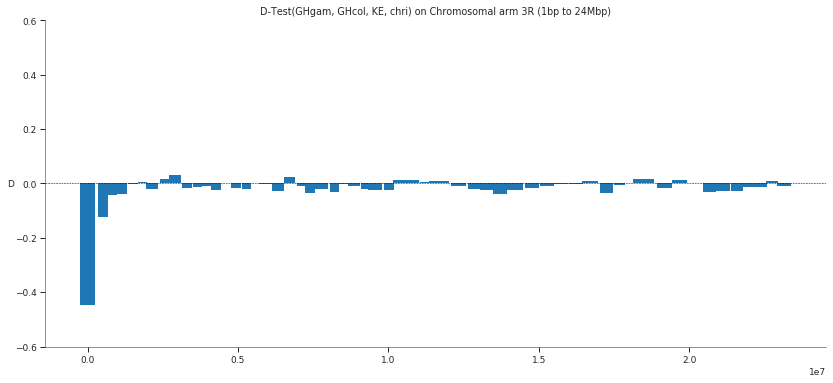

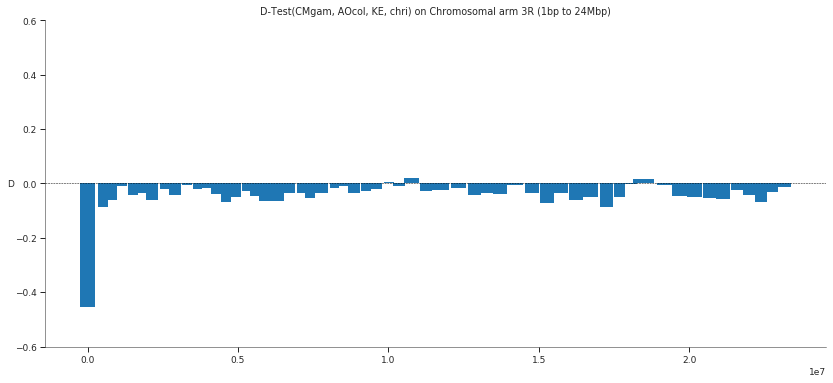

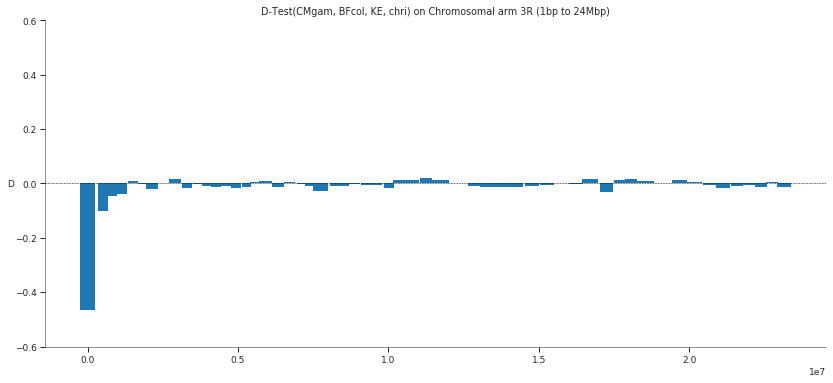

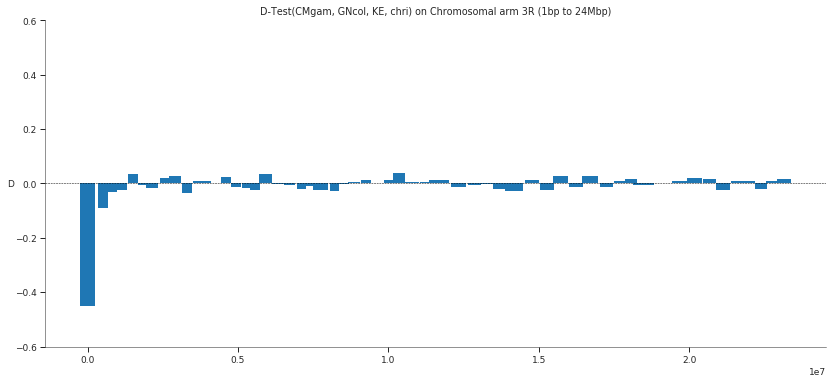

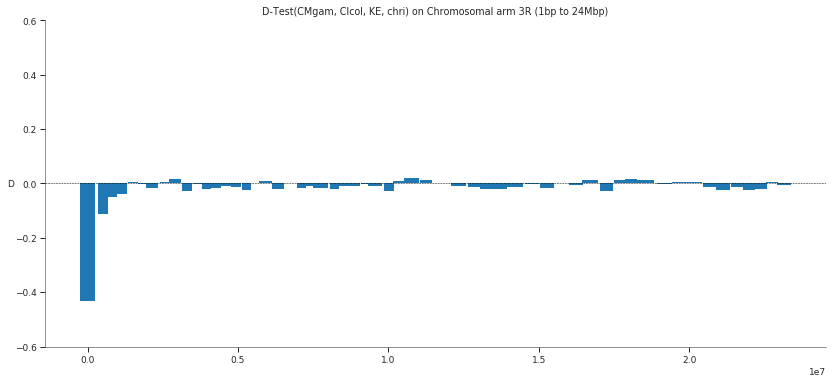

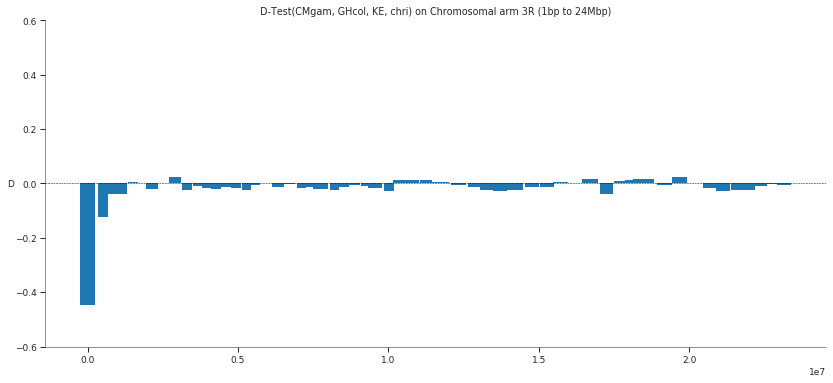

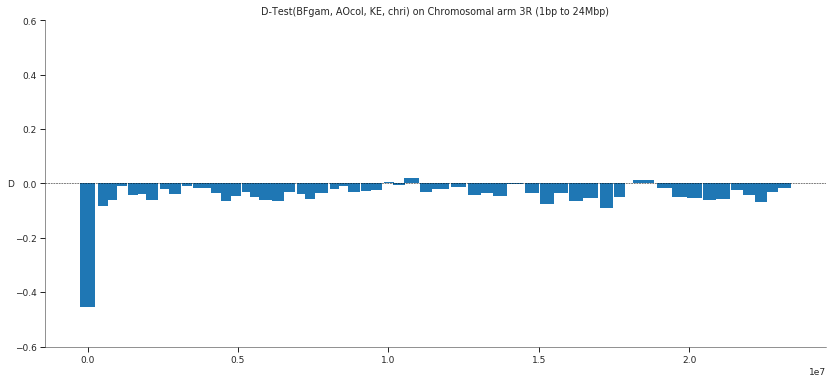

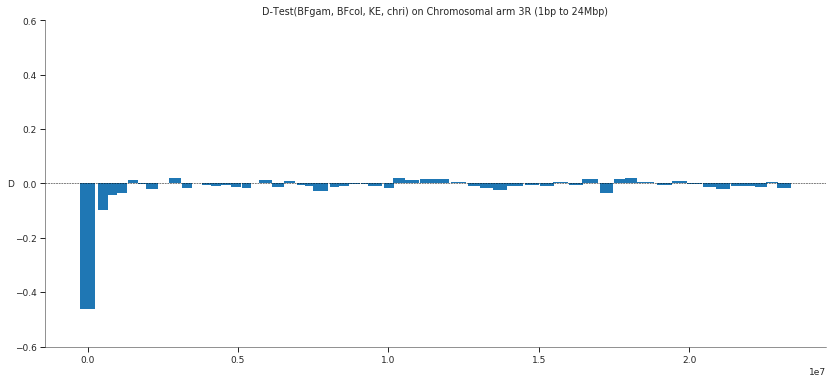

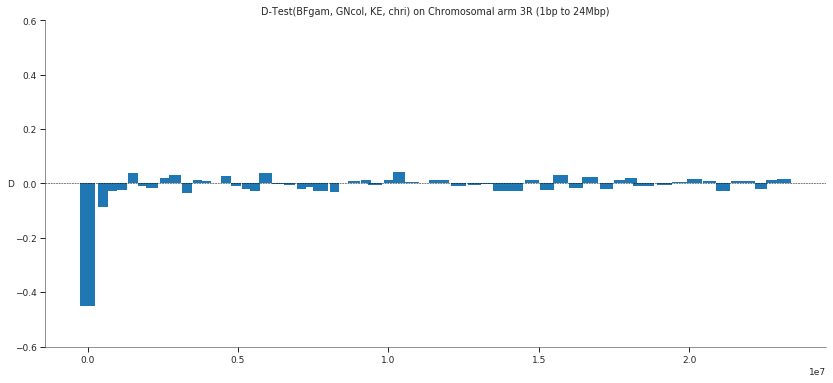

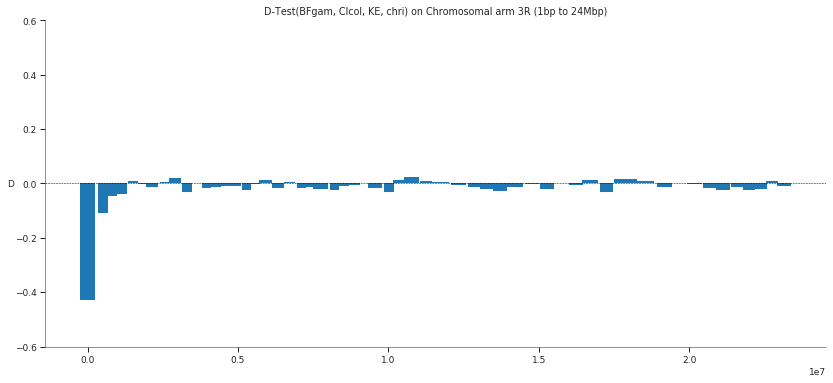

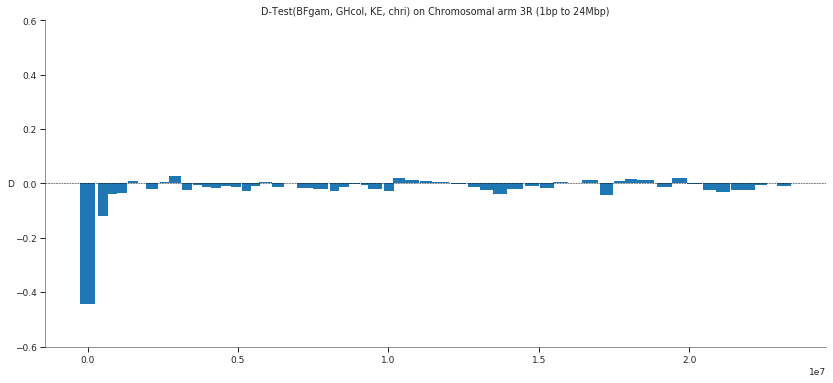

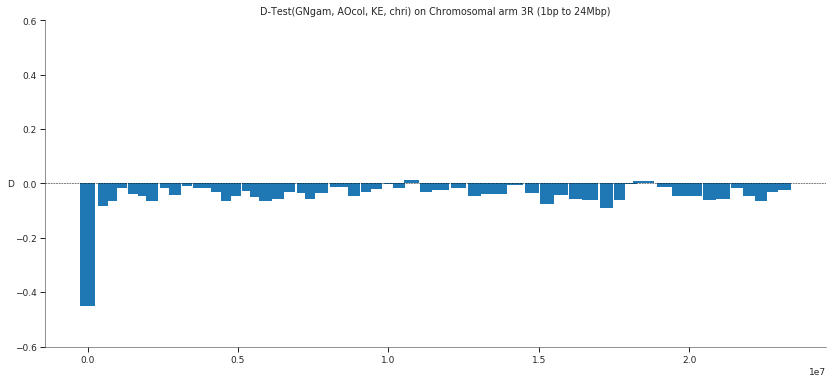

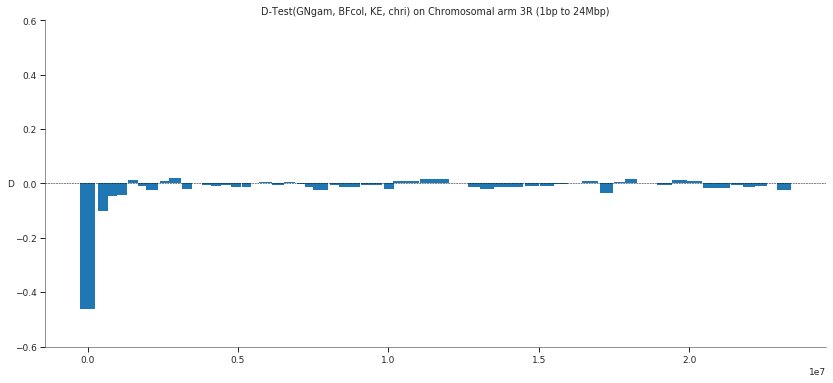

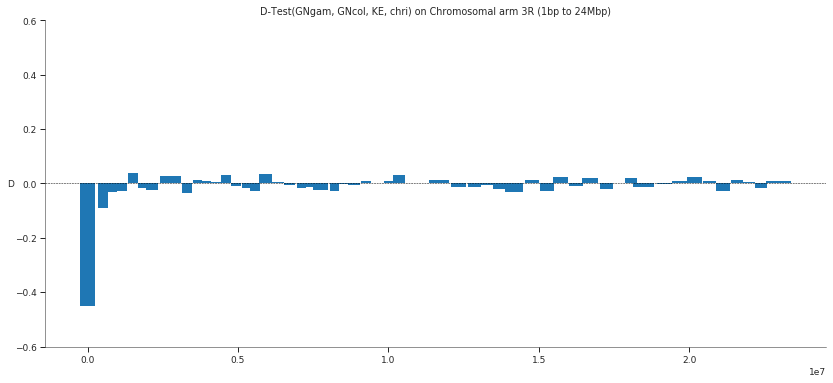

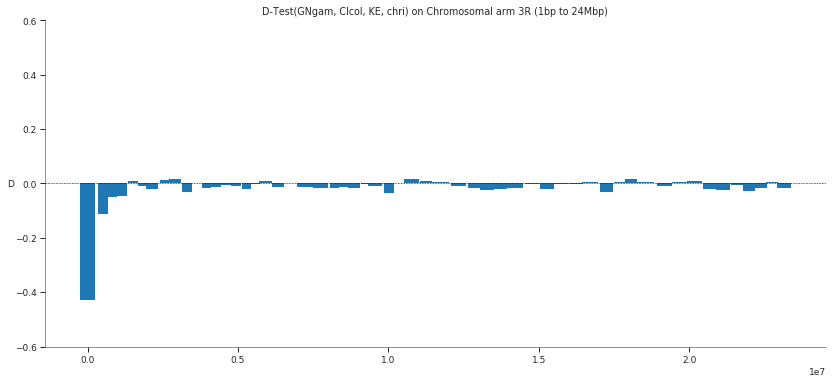

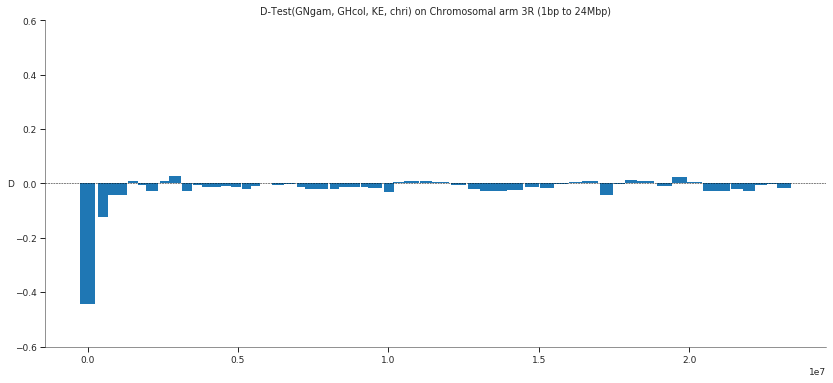

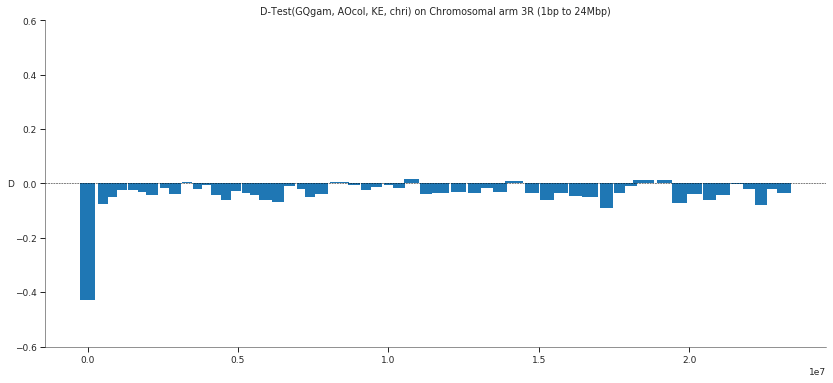

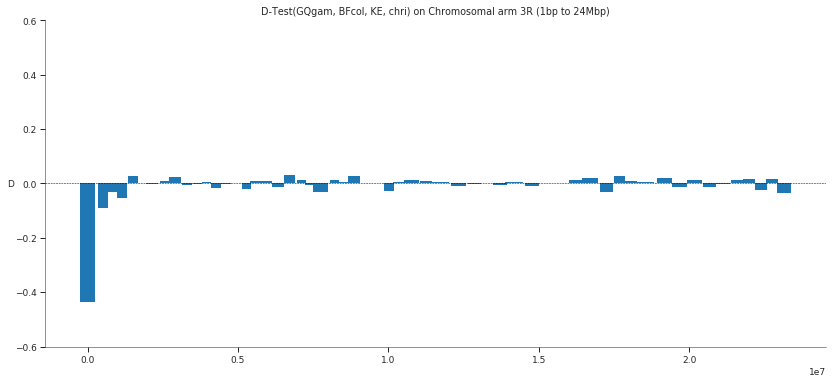

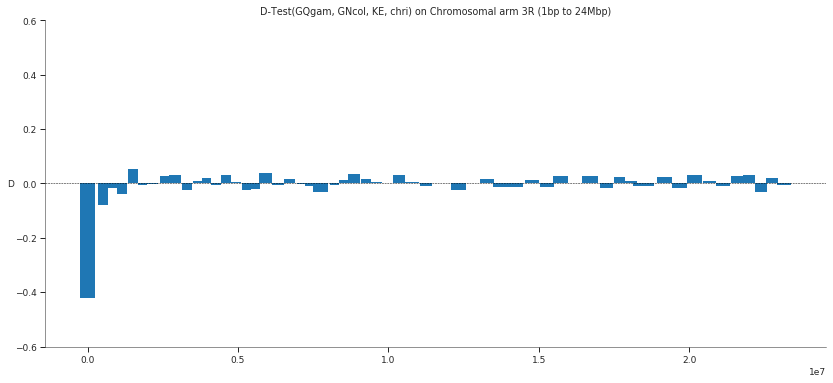

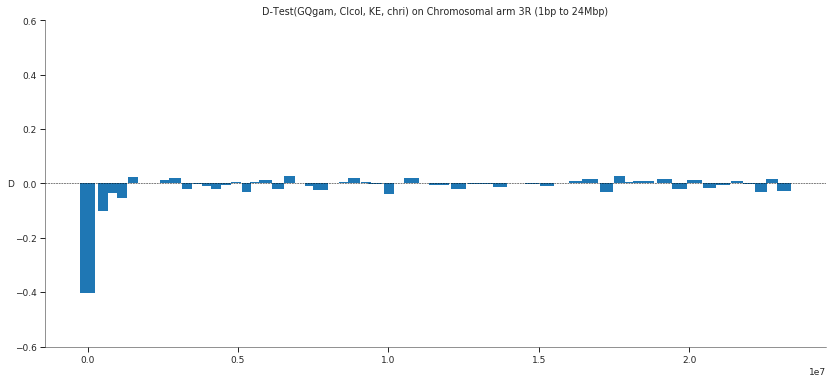

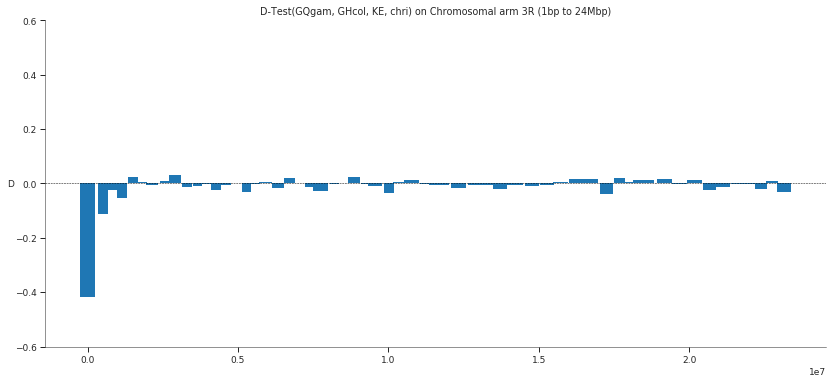

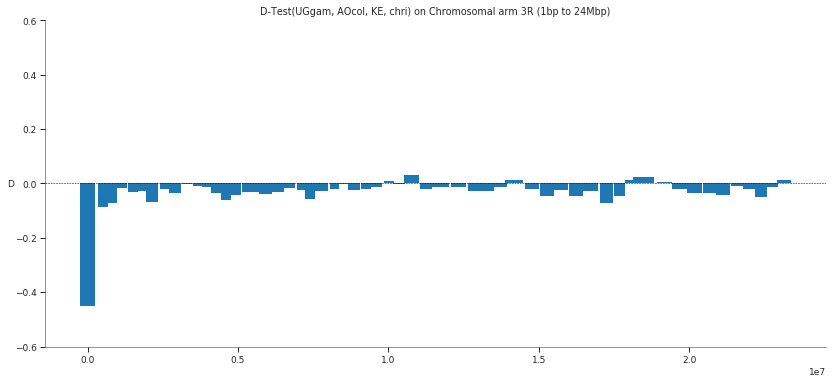

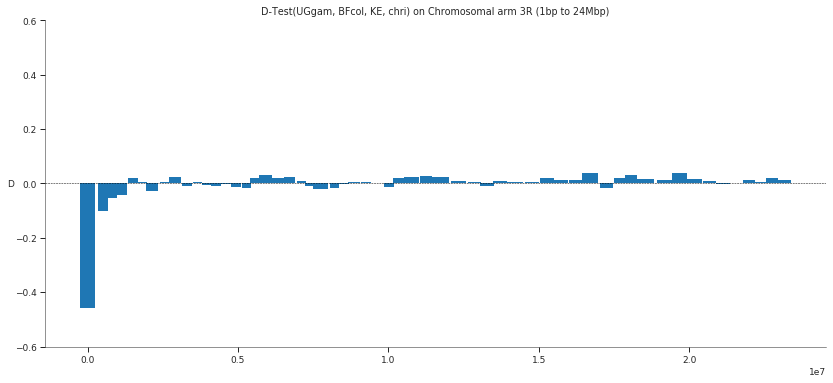

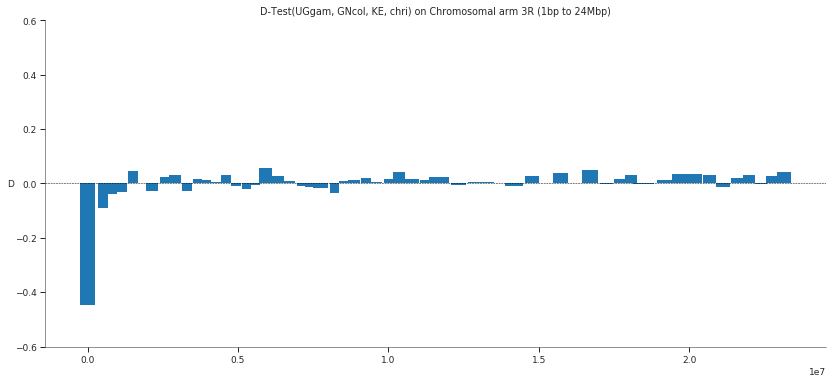

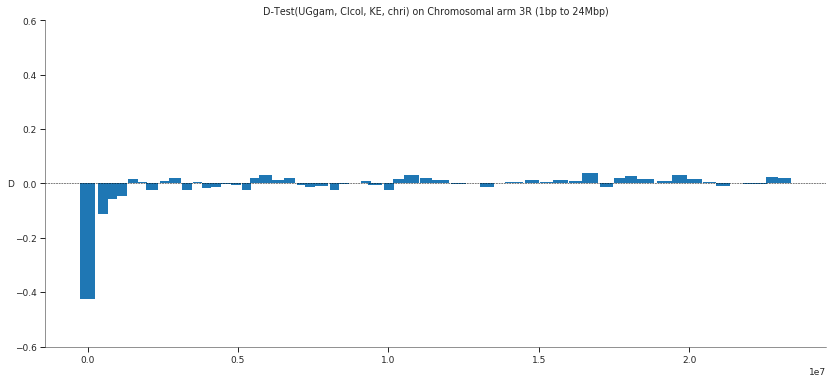

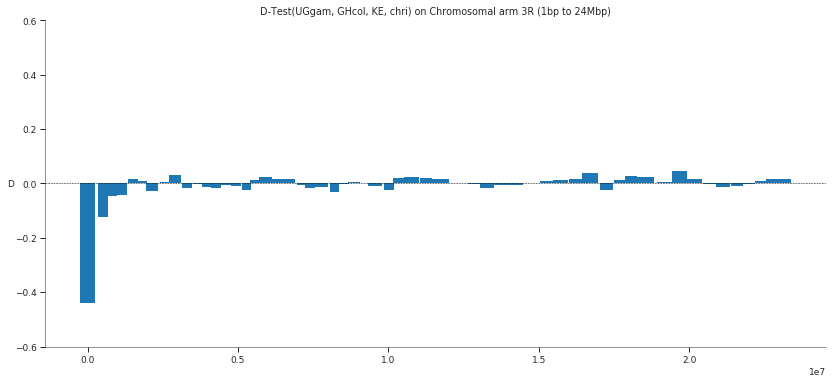

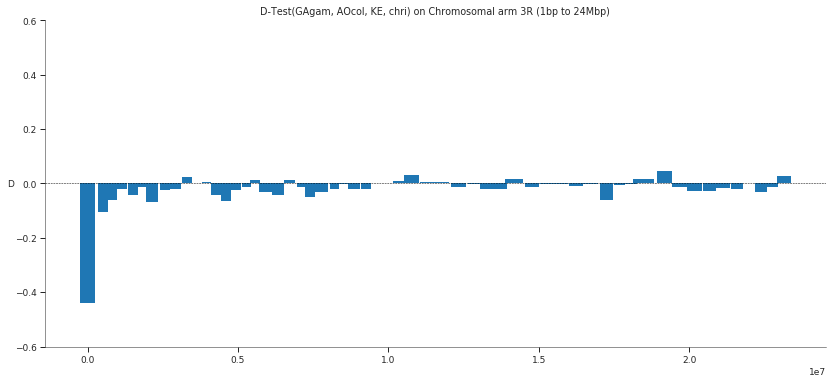

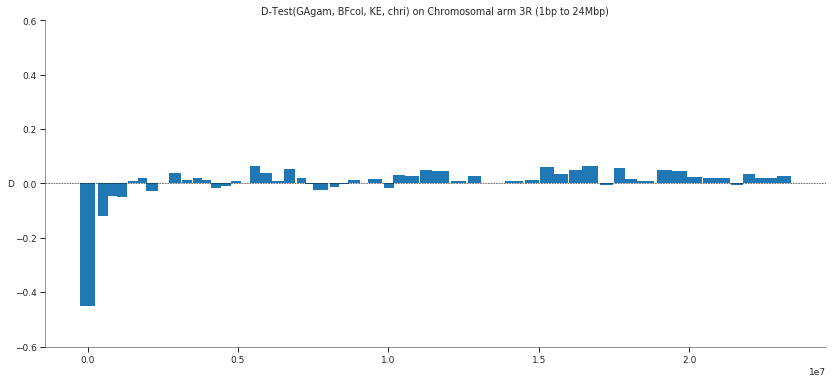

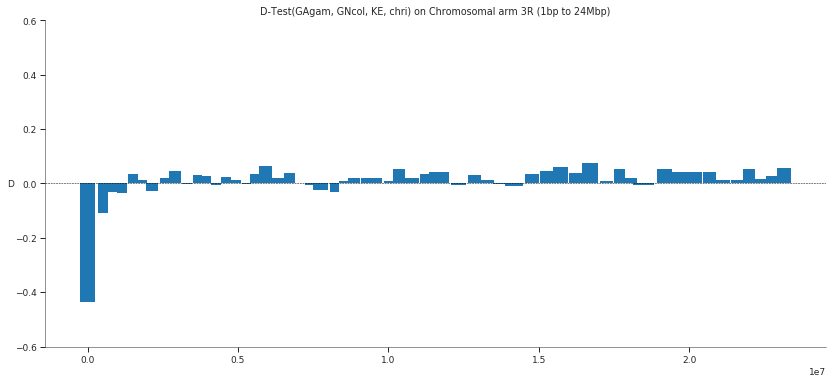

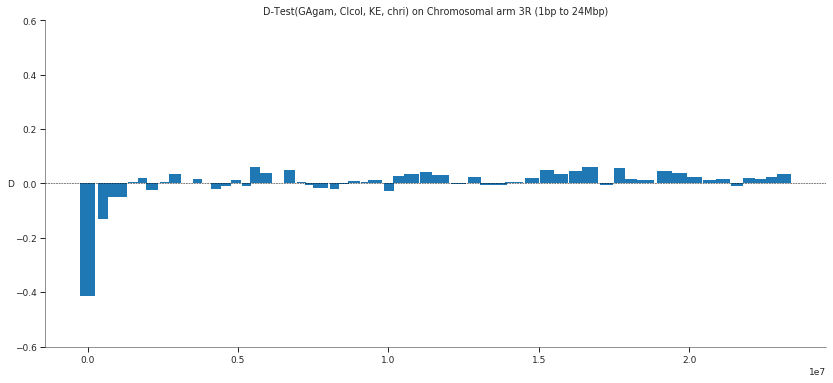

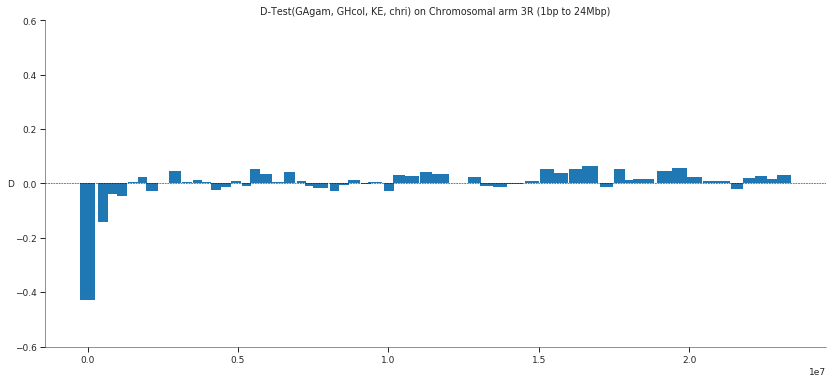

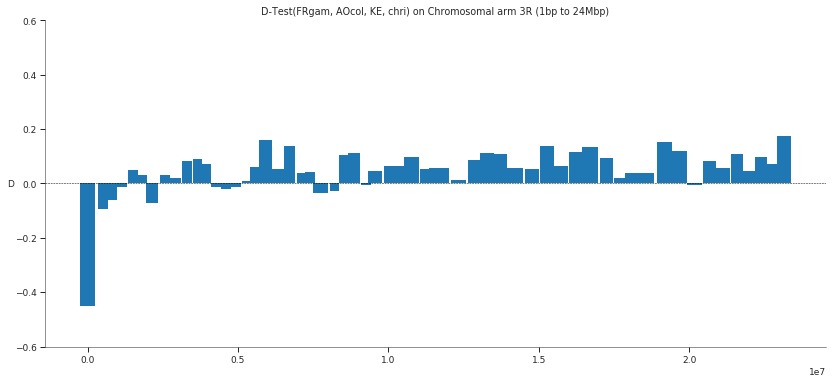

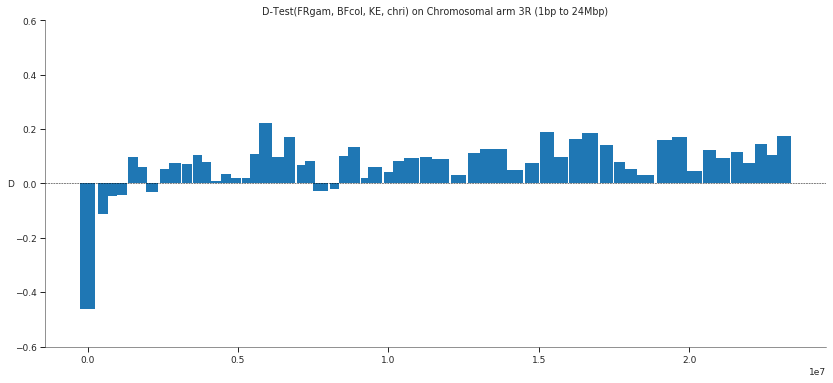

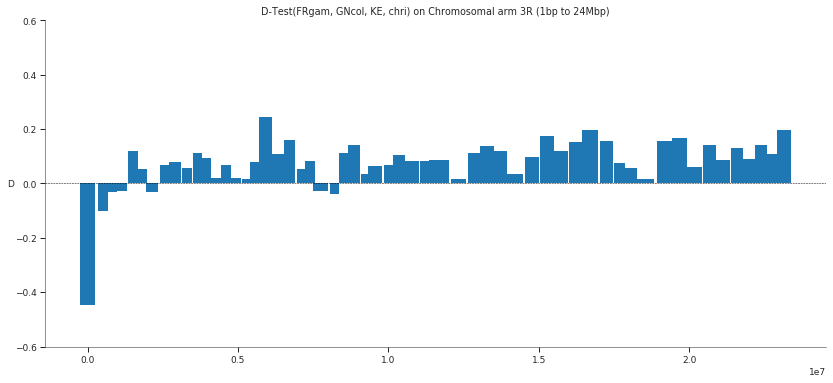

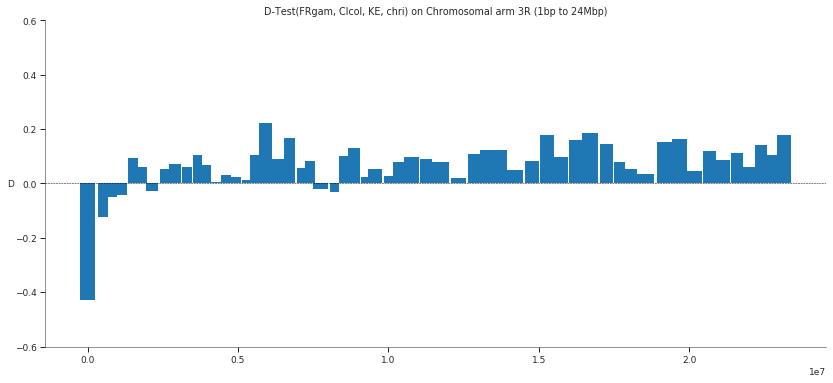

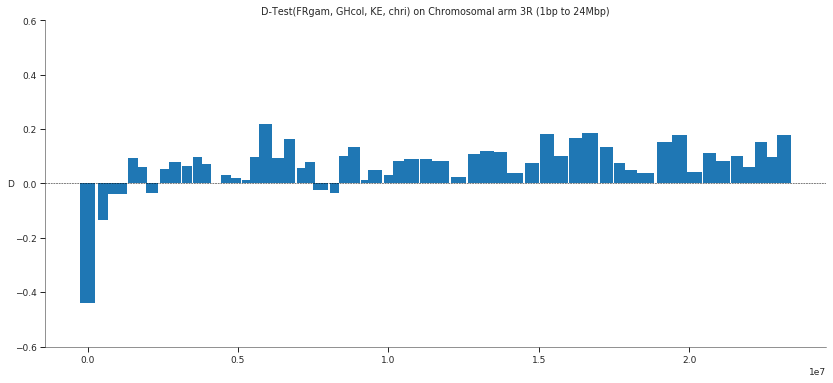

In [24]:
# load variant positions
#title = results_3R['Test']
pos = callset_biallel['3R']['variants']['POS'][loc]
block_starts = allel.moving_statistic(pos, statistic=np.min, size=100000)
block_stops = allel.moving_statistic(pos, statistic=np.max, size=100000)
block_widths = block_stops - block_starts
title = results_3R['Test']
### qui bisogna fare un ciclo:
for i in range(len(bloks_3R)):	
		ylim=(-.6, .6)
		fig, ax =  plt.subplots(figsize=(14, 6))
		ax.bar(block_starts, bloks_3R[i], width=block_widths, linewidth=0)
		ax.axhline(0, color='k', linestyle='--')
		ax.set_ylabel('D', rotation=0, ha='center', va='center')
		ax.set_ylim(*ylim)
		ax.set_title('%s on Chromosomal arm 3R (1bp to 24Mbp)' %(title[i]))
		sns.despine()        
i+=1

------------------------------------------------------------
## Far-West pops

In [25]:
A = an_gam
B = an_fw
C = an_col
D = 'chri'

In [26]:
results_3R, bloks_3R, plot_3R = plot_test('3R', A,B,C,D, blen = 100000)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


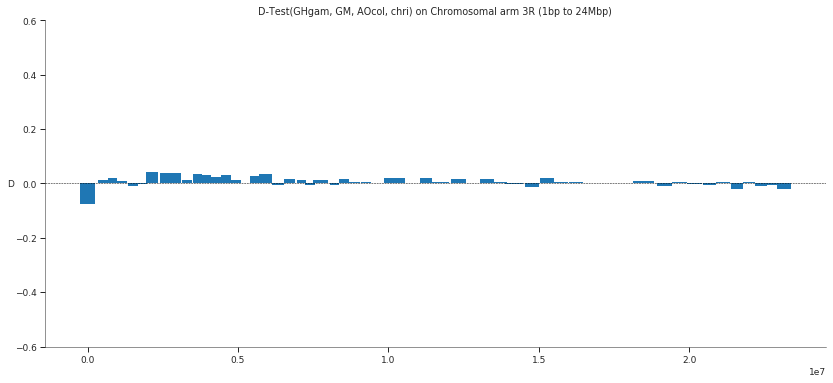

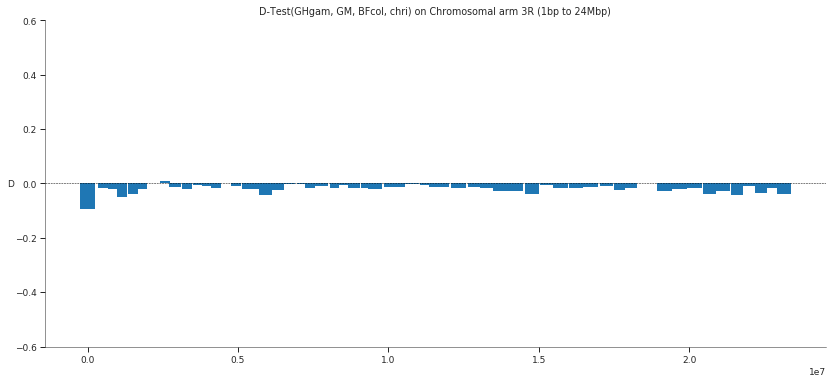

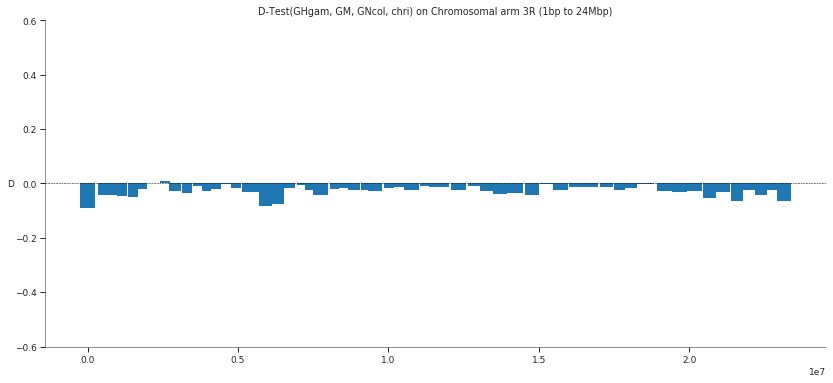

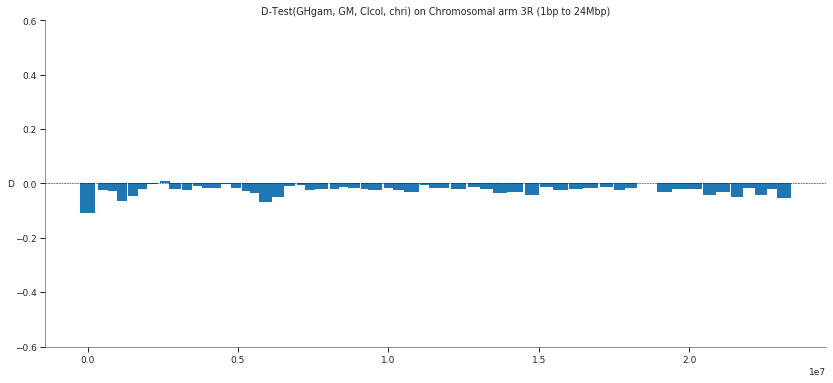

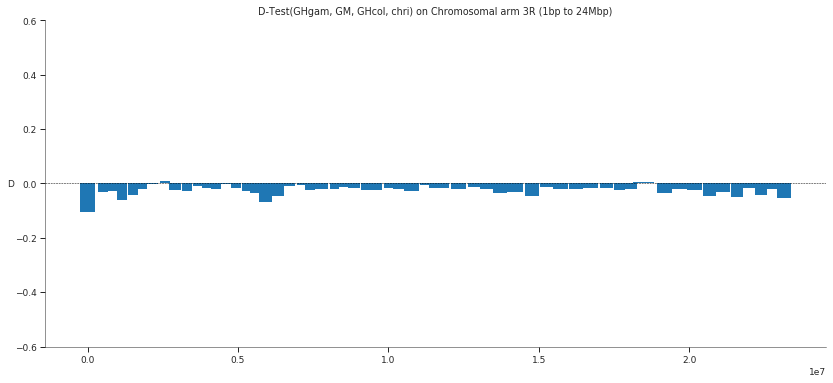

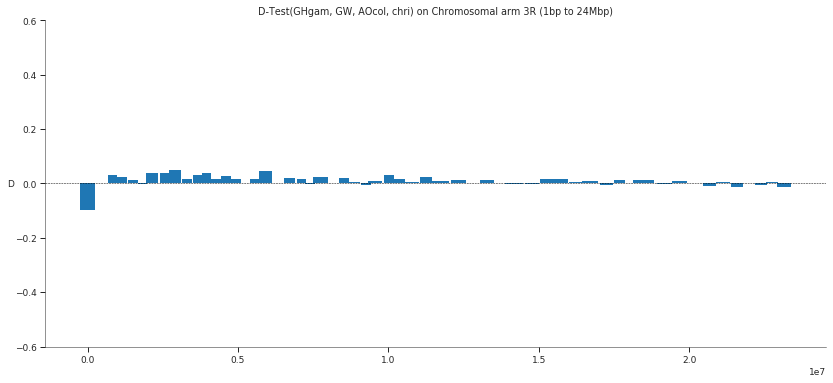

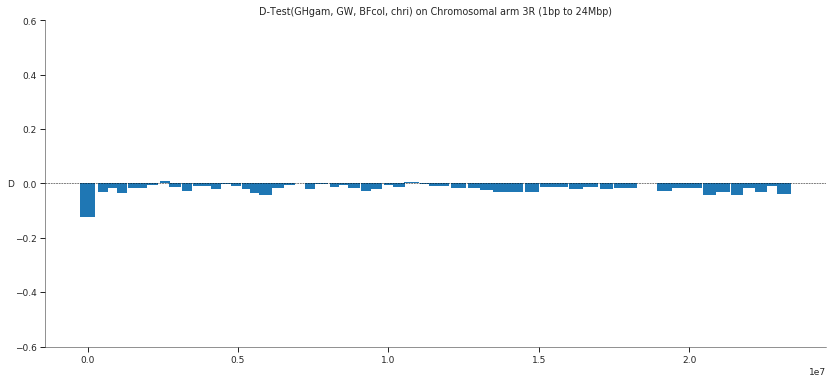

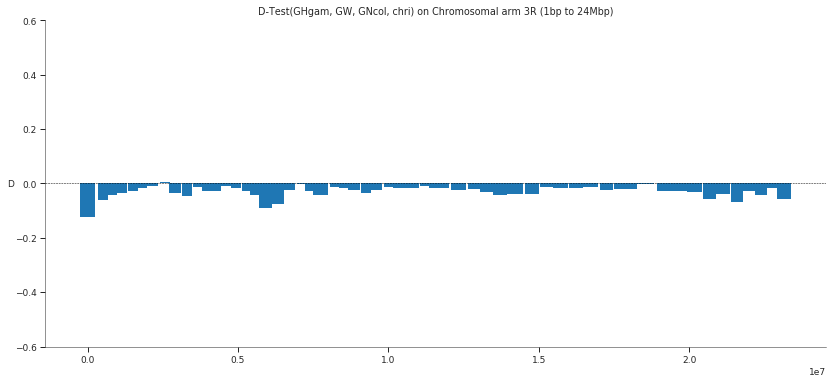

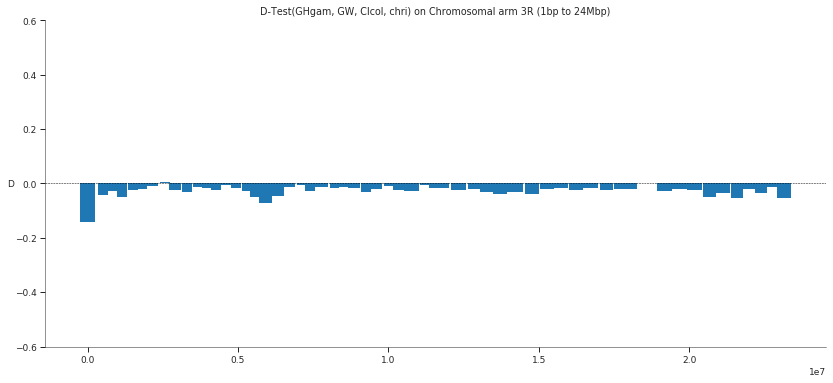

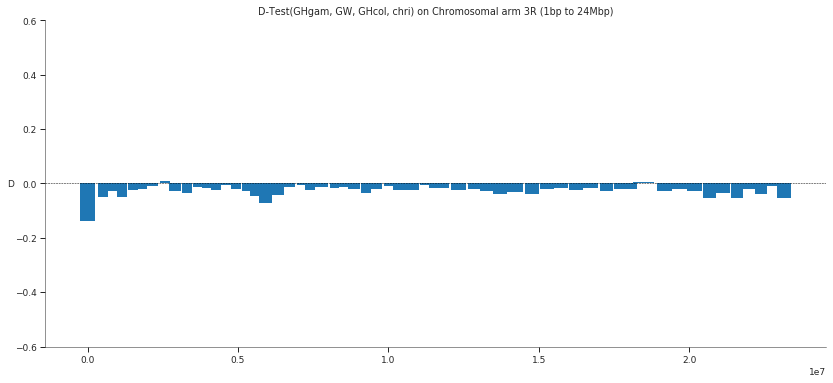

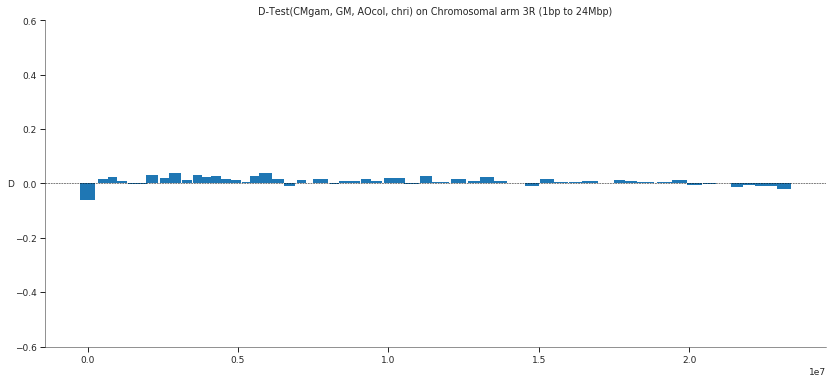

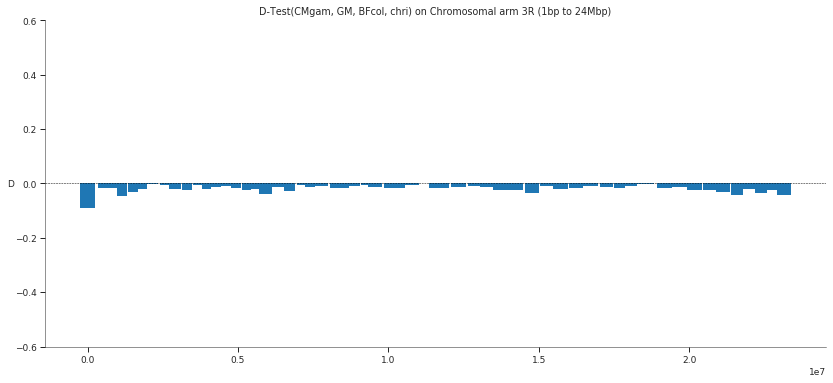

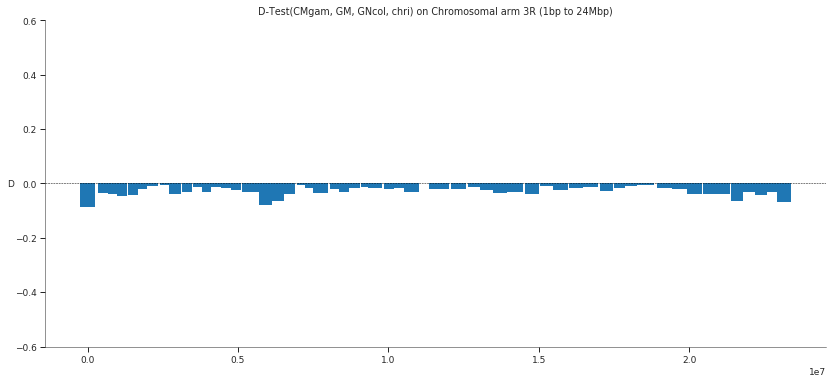

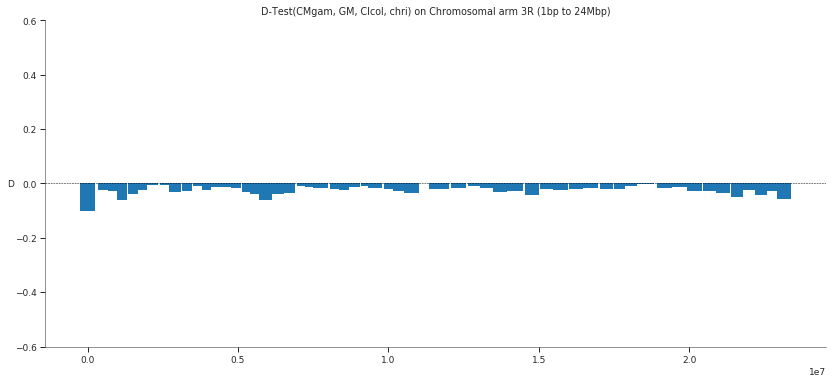

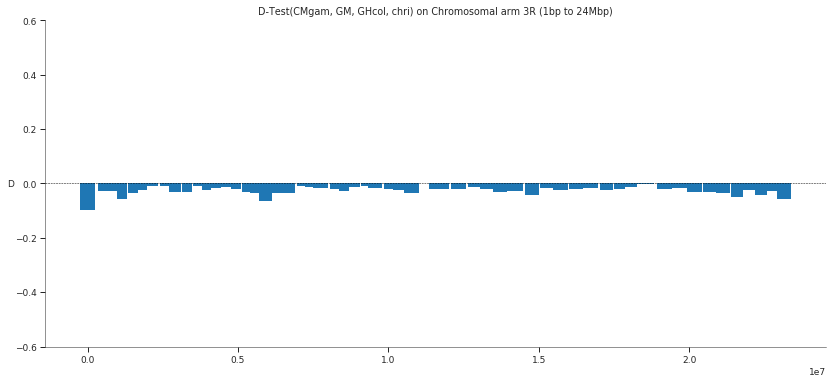

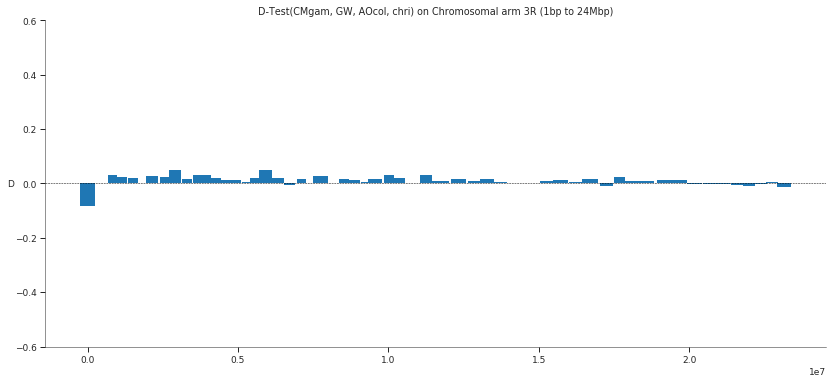

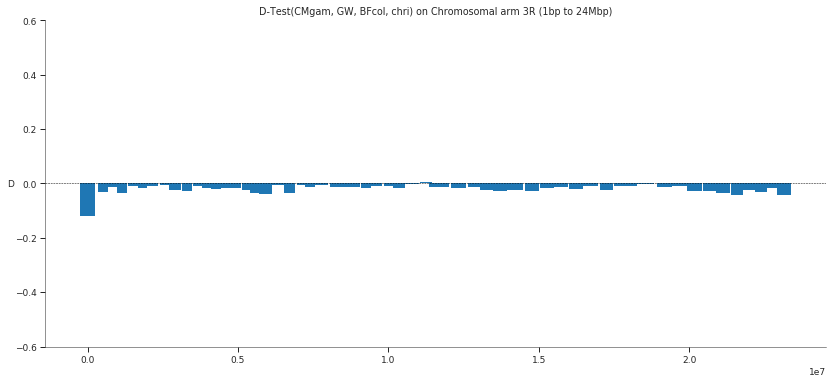

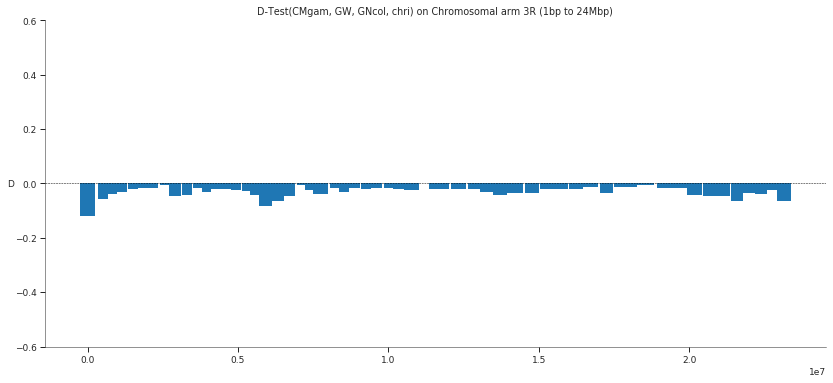

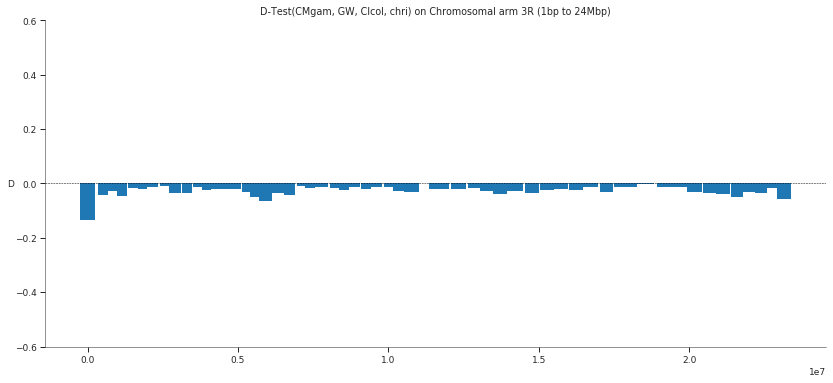

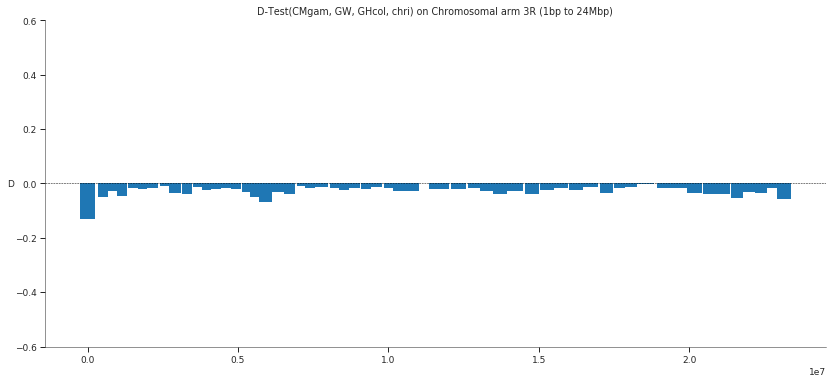

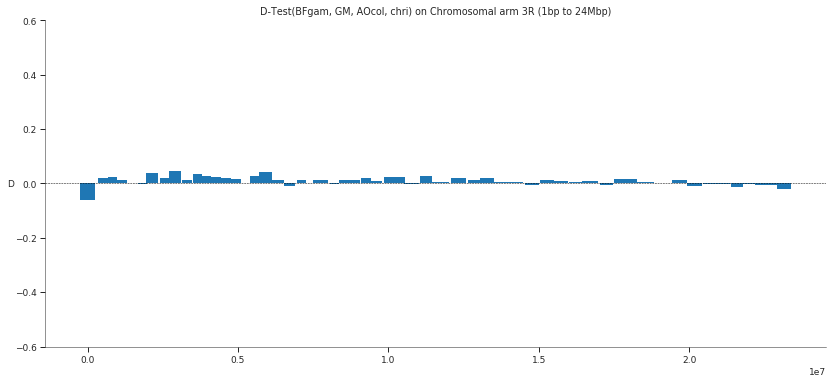

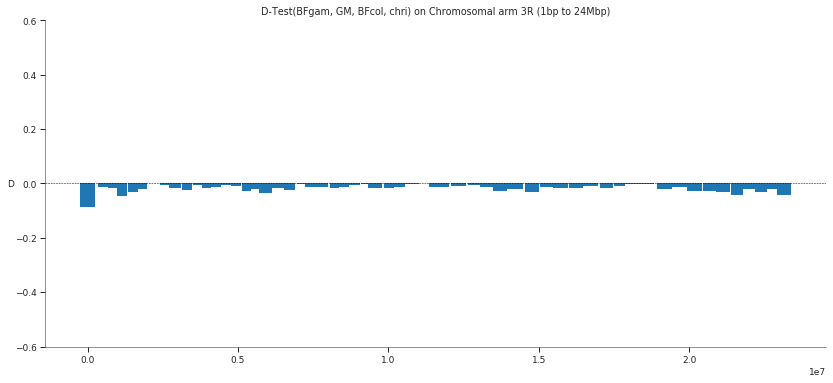

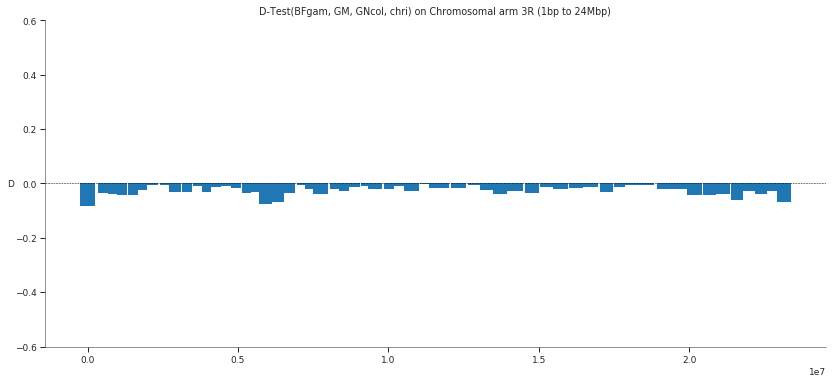

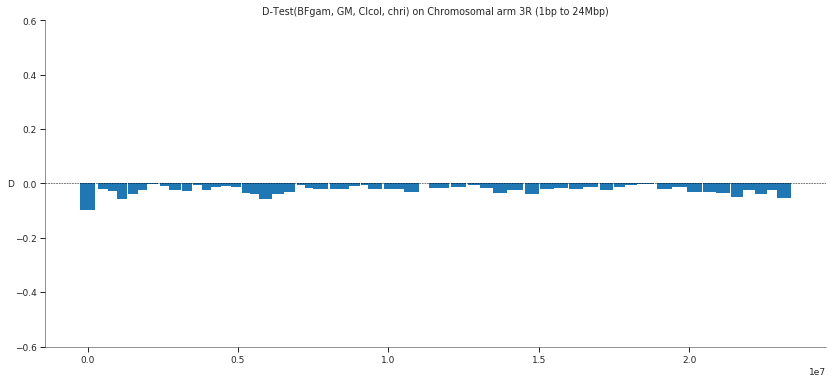

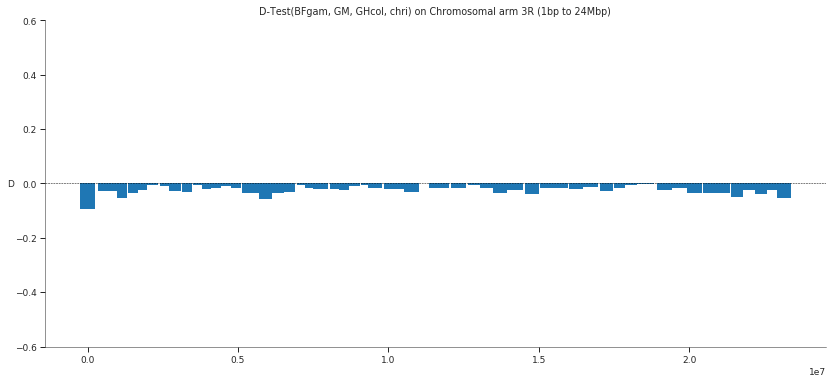

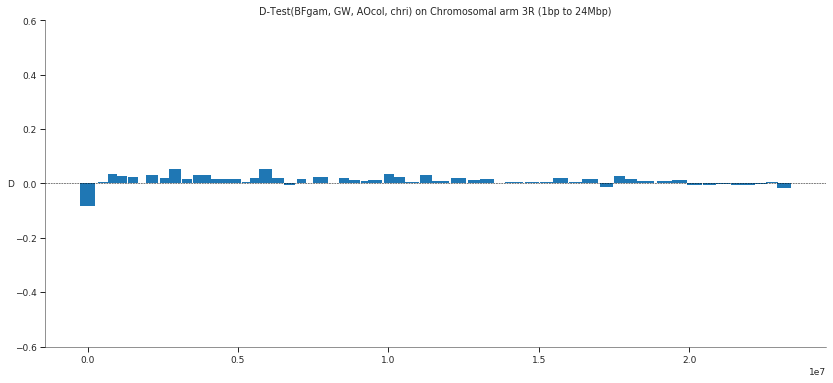

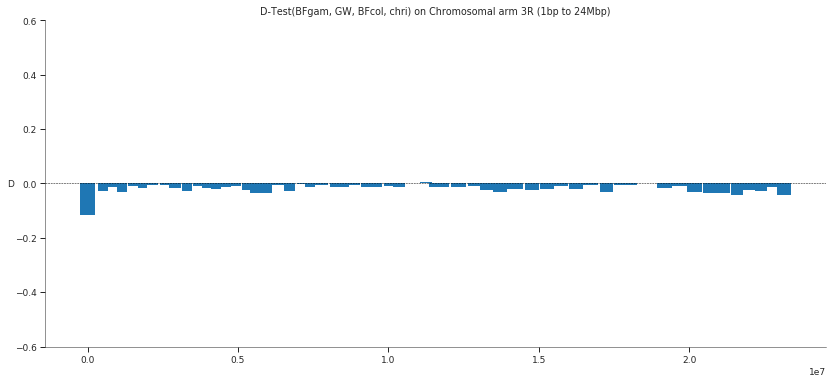

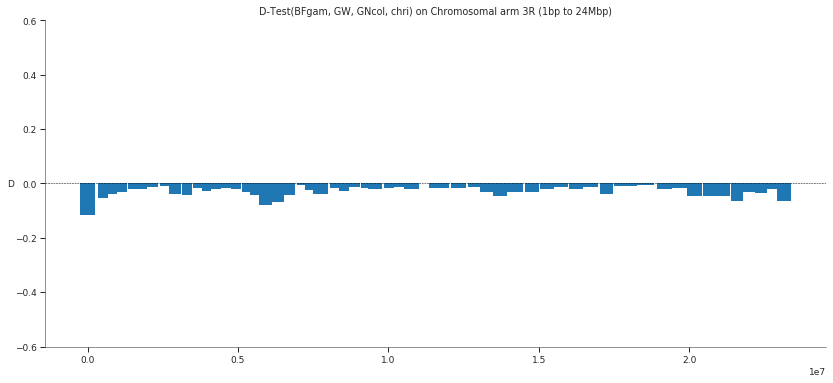

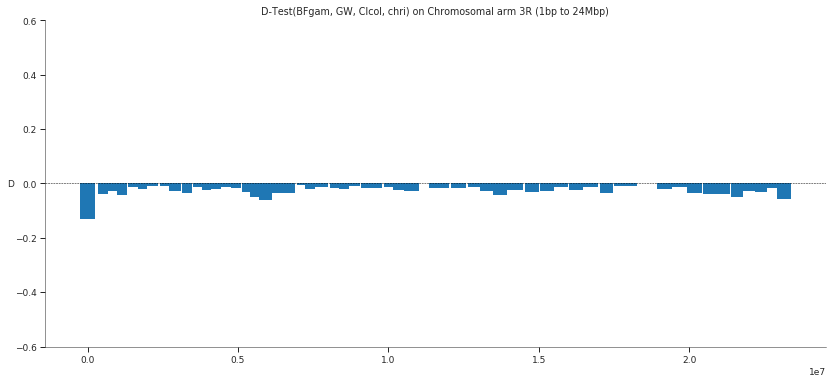

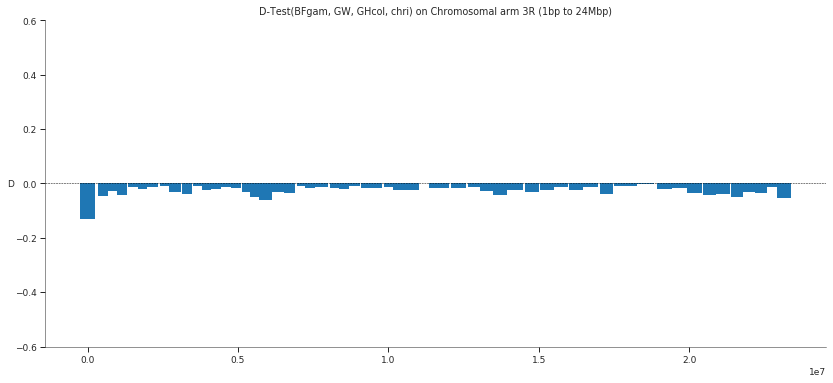

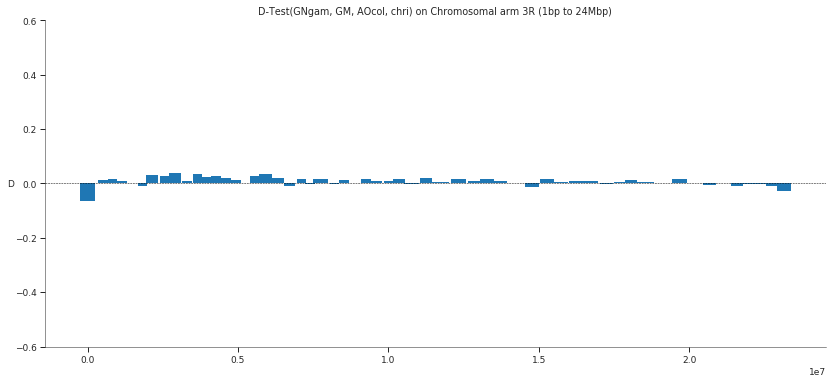

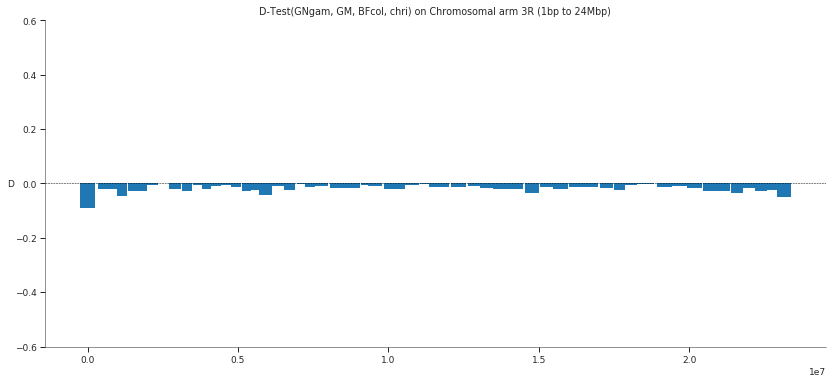

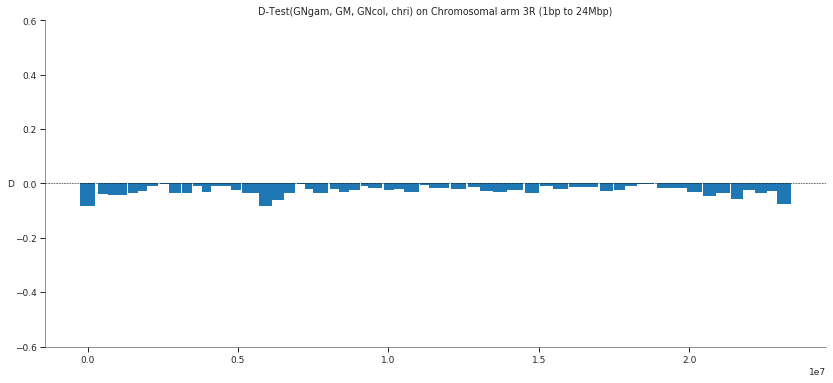

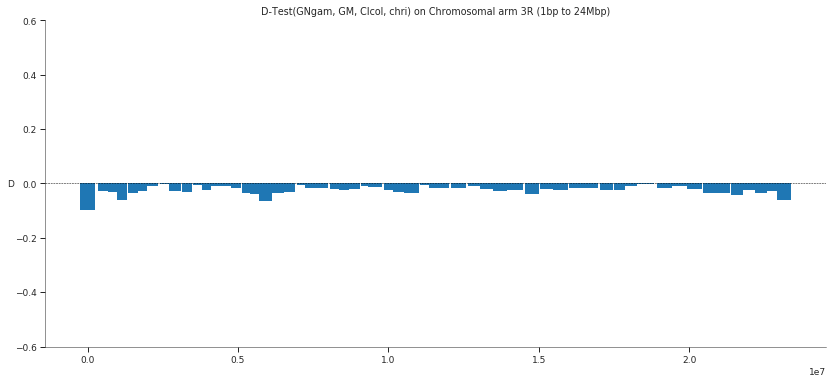

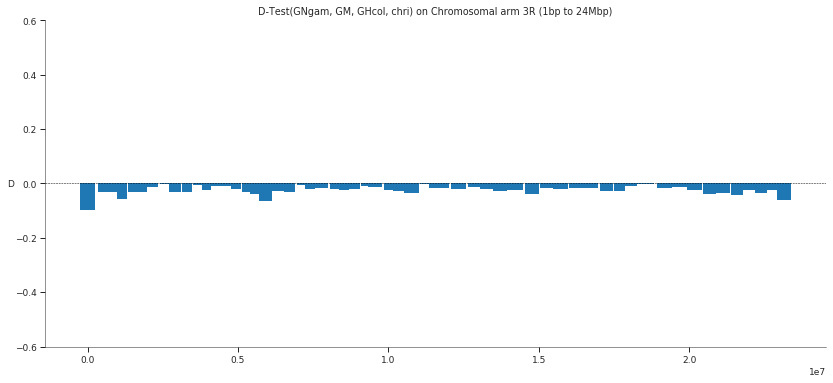

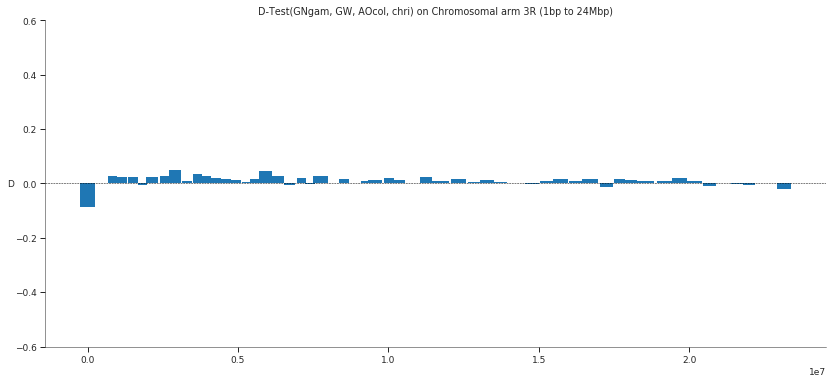

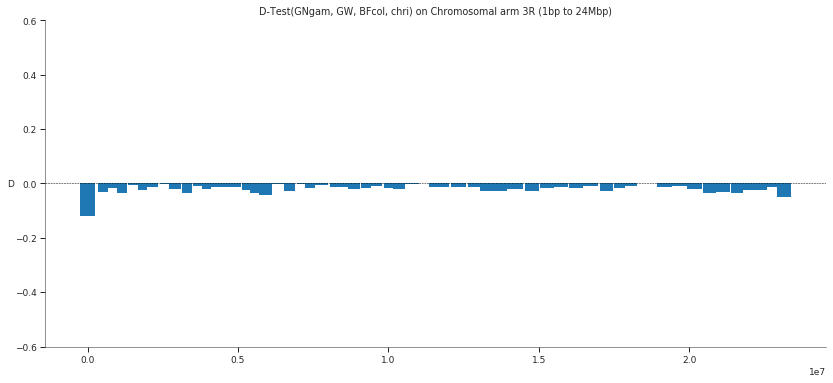

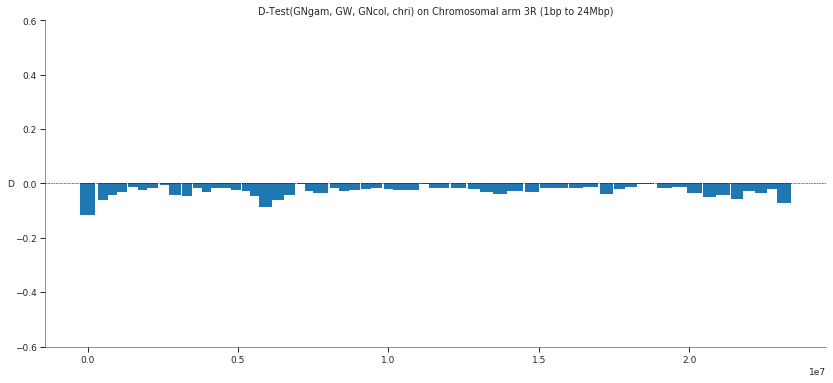

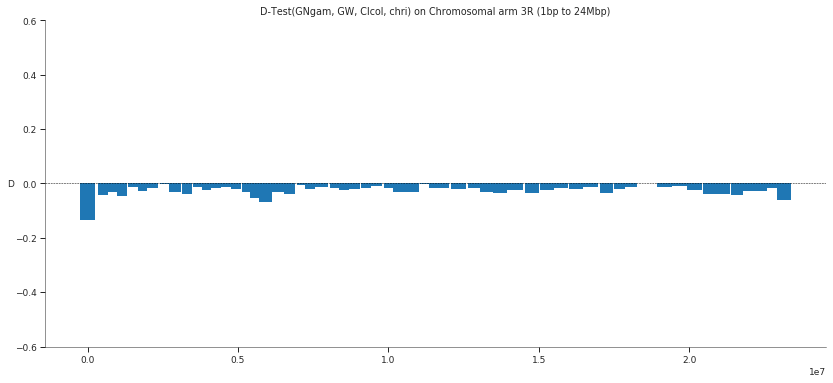

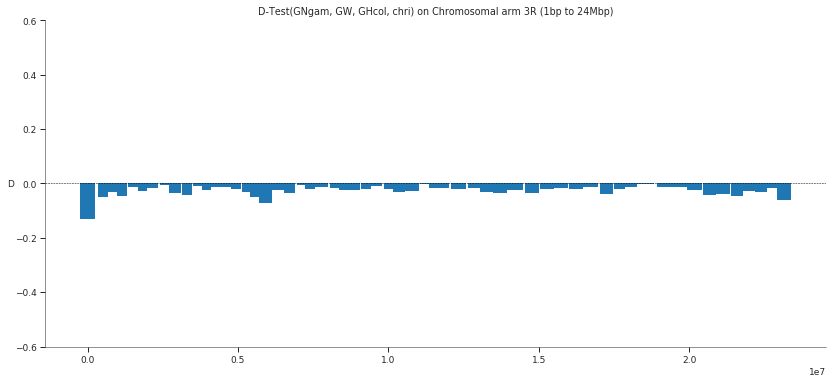

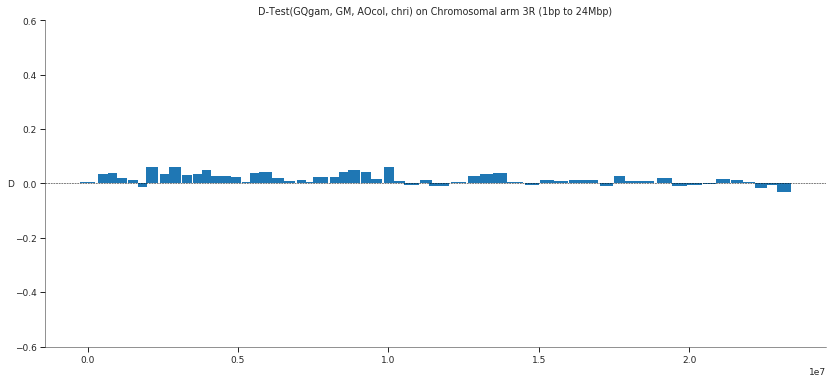

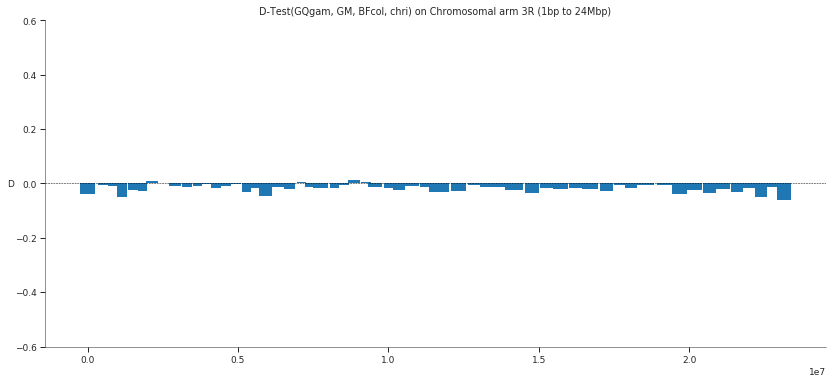

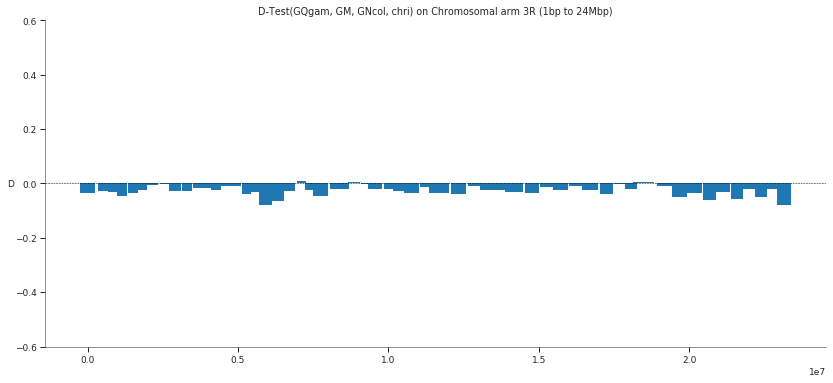

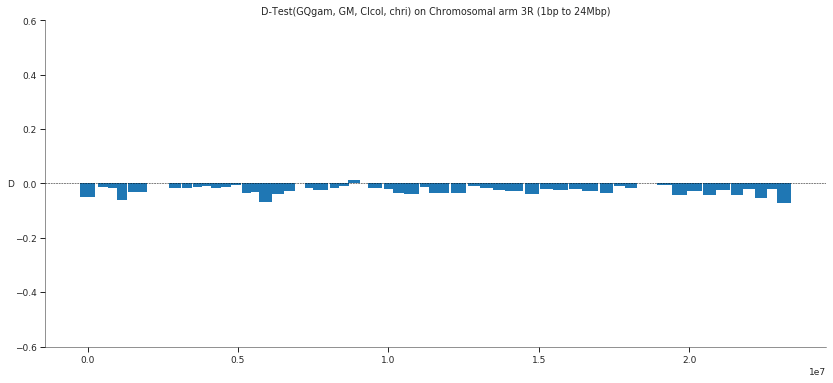

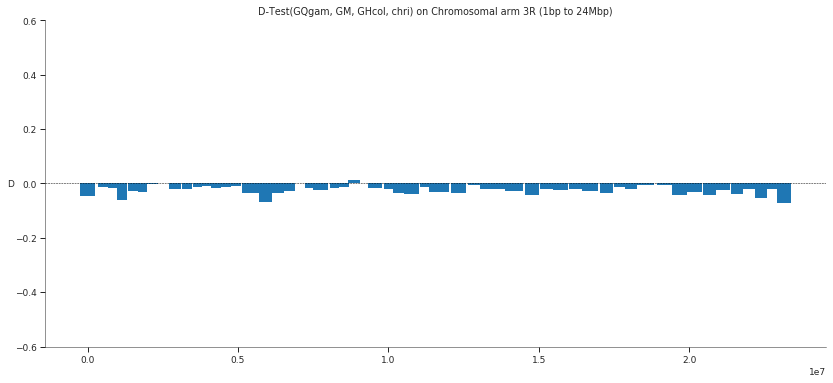

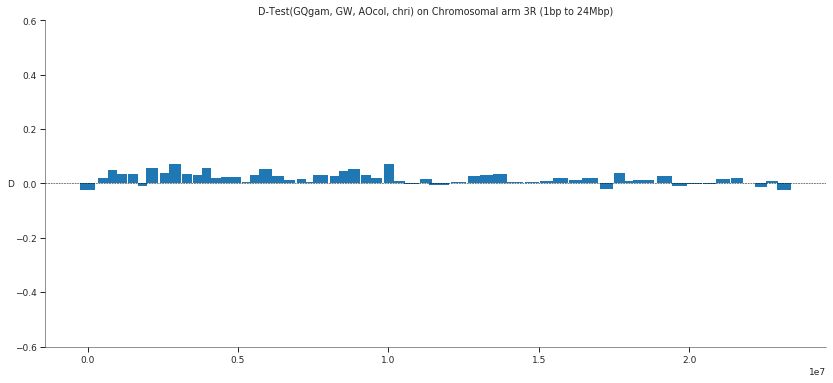

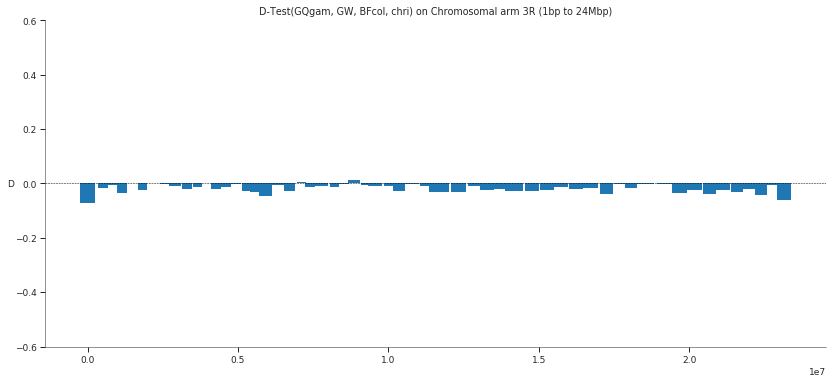

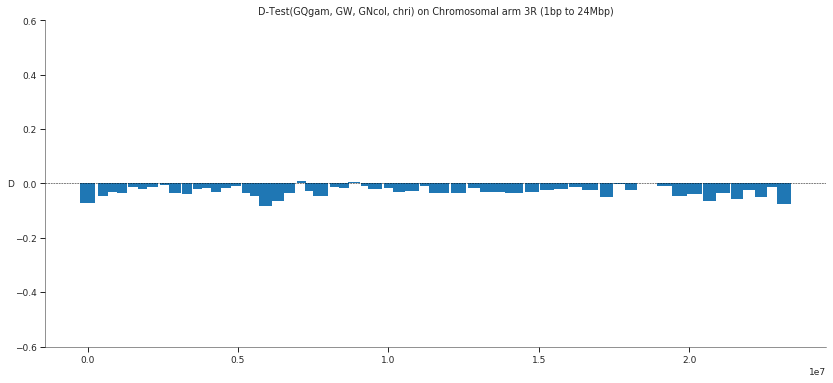

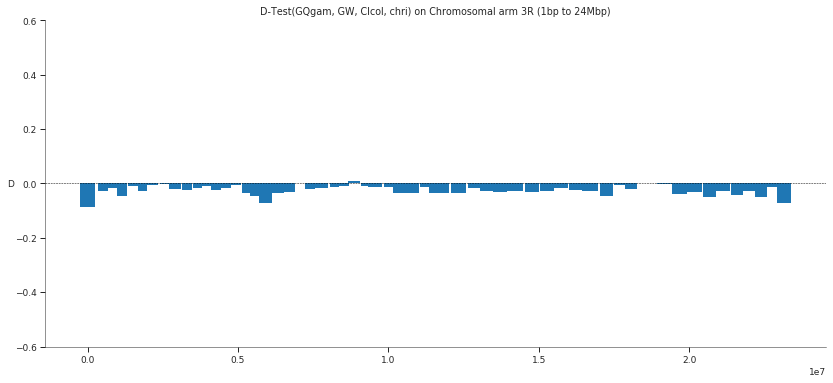

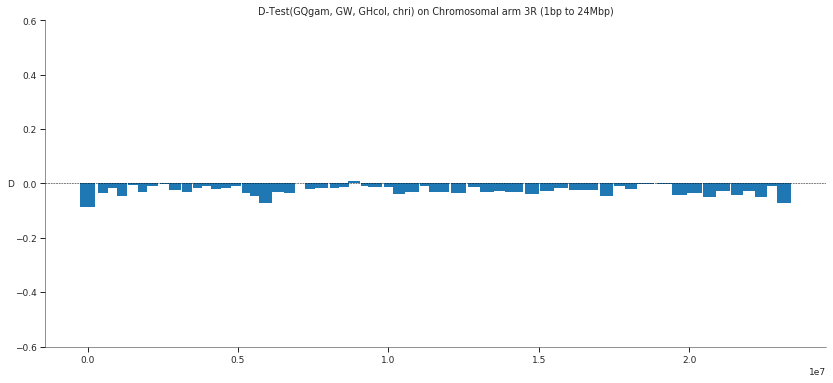

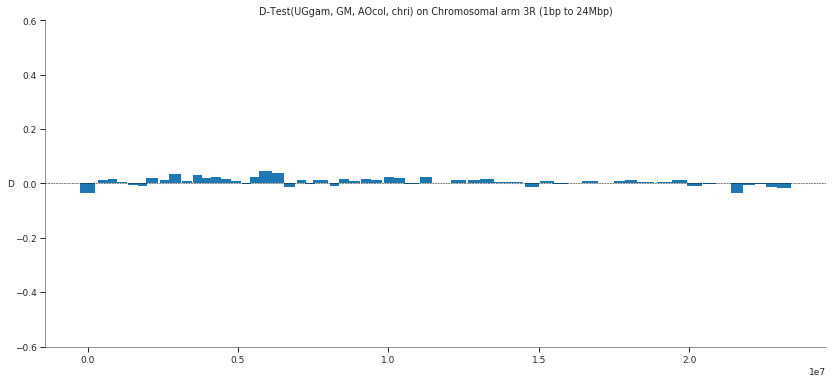

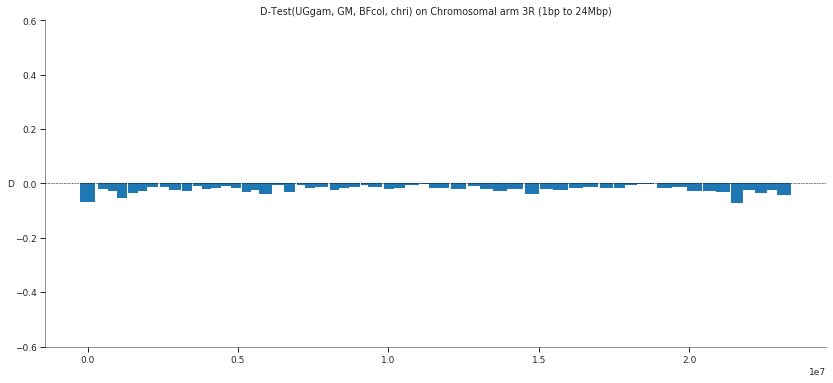

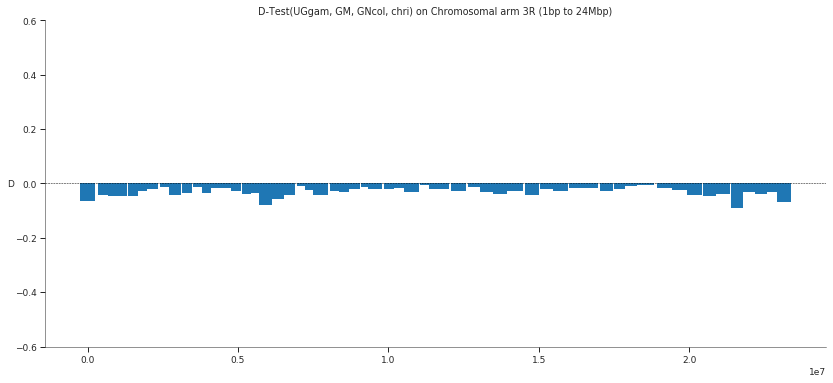

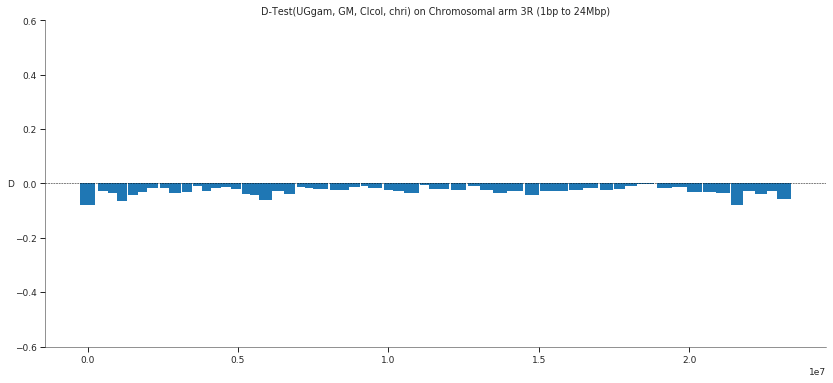

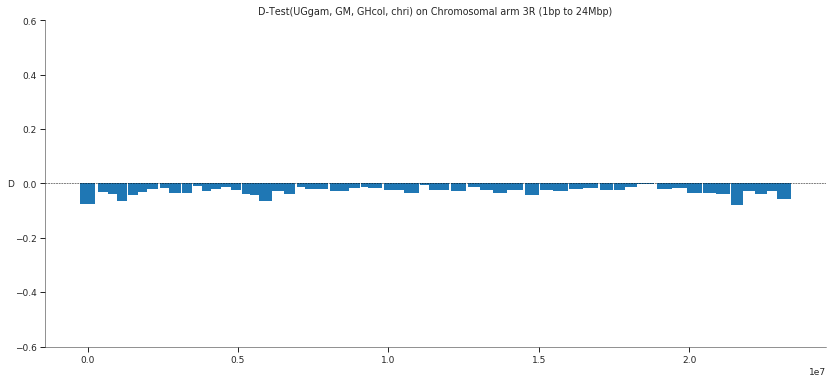

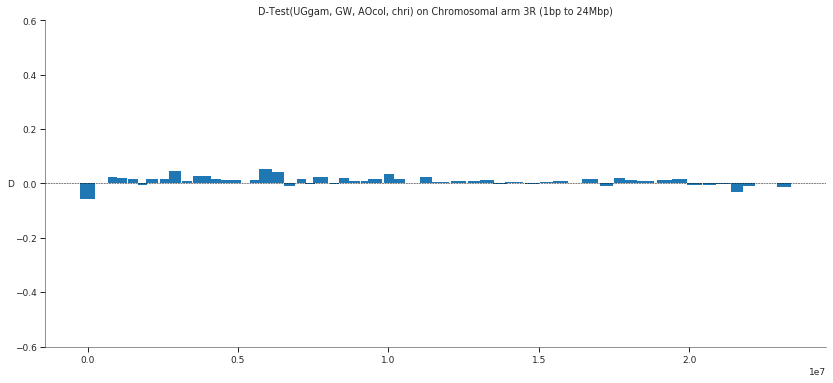

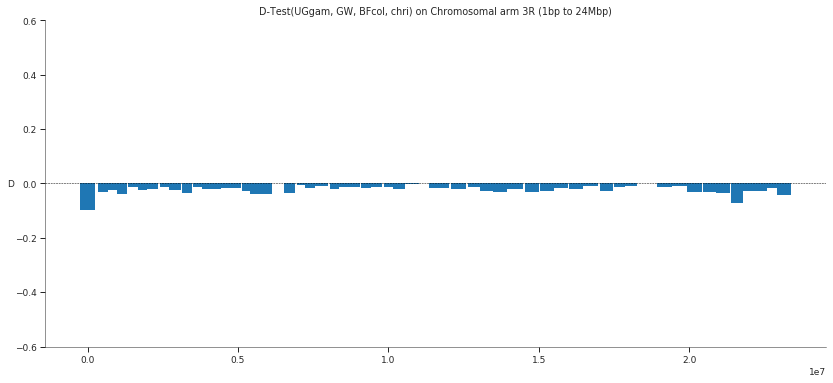

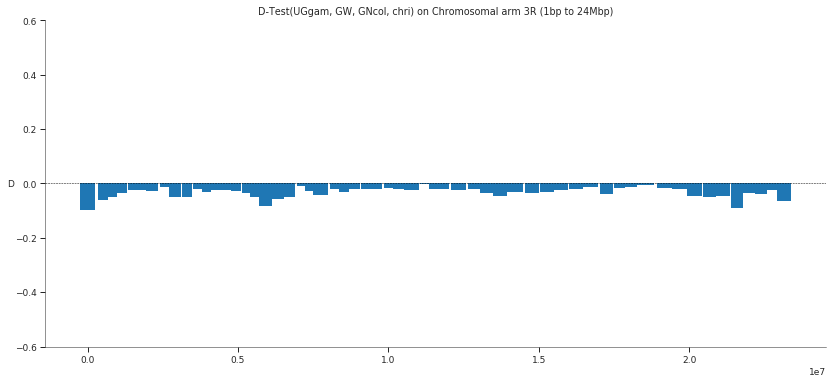

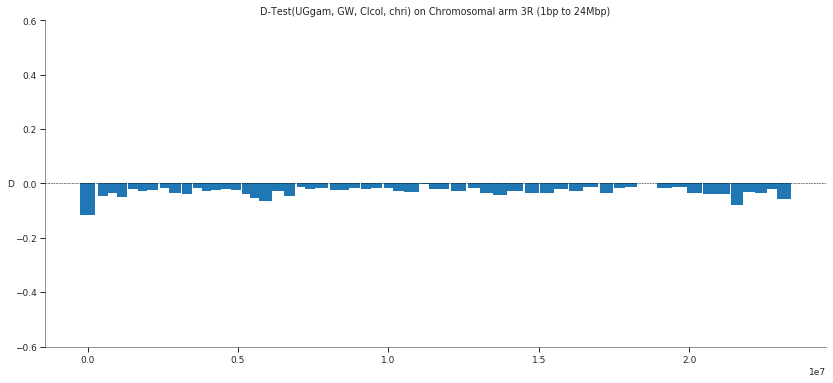

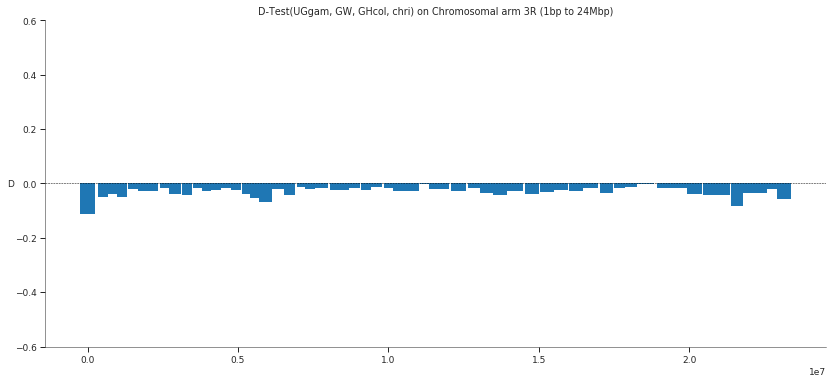

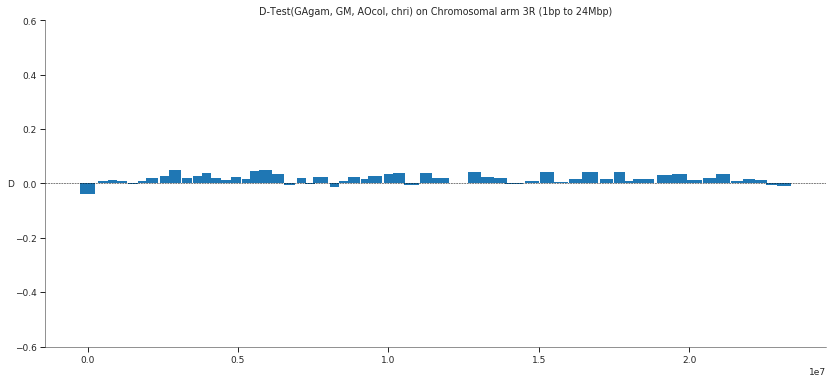

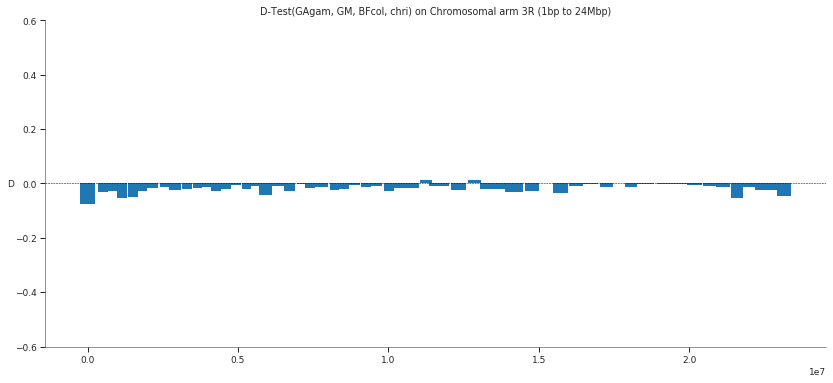

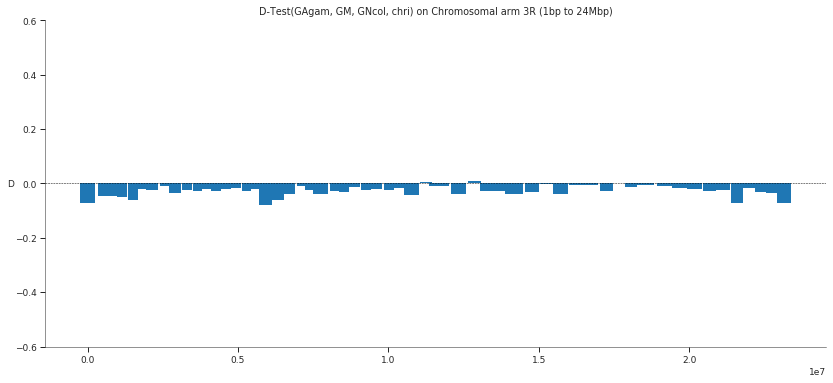

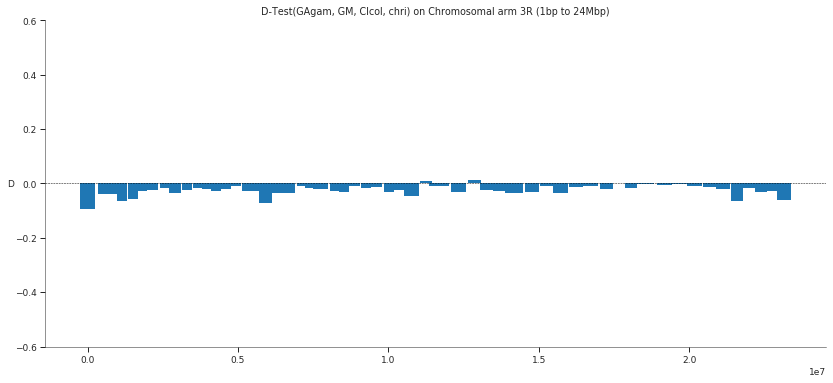

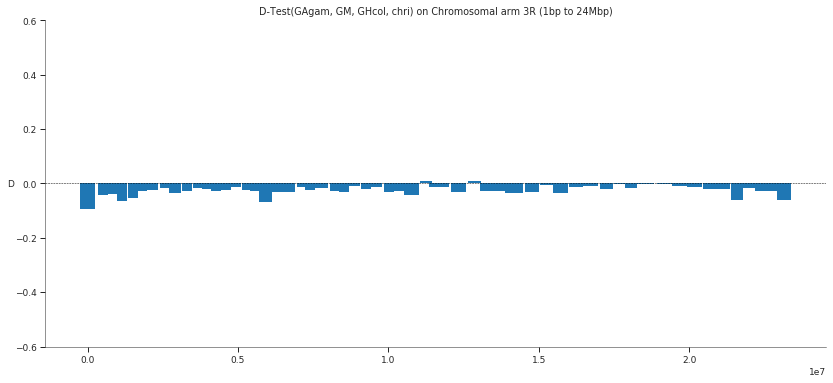

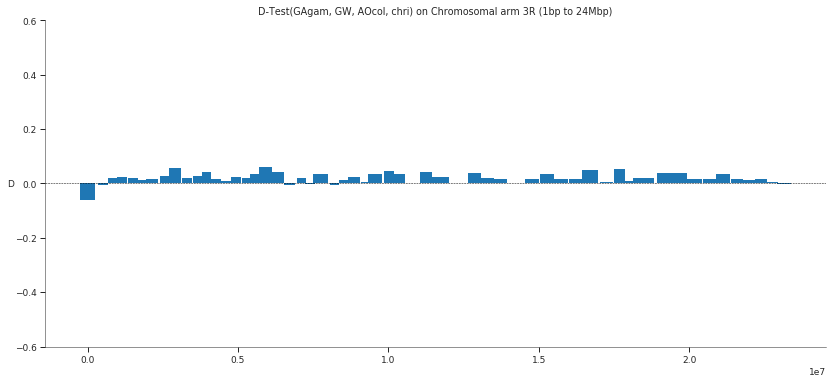

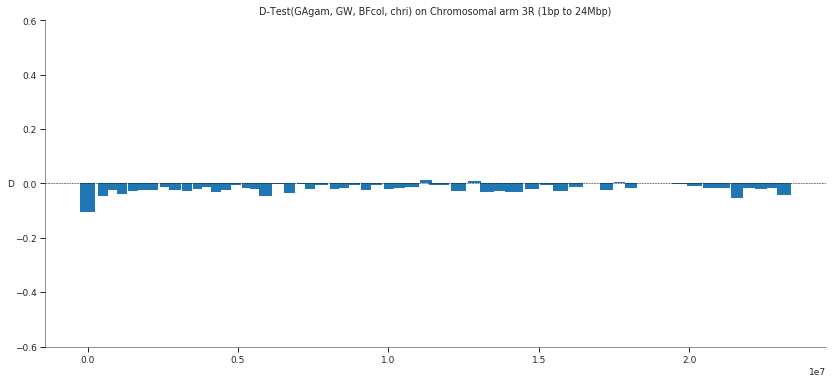

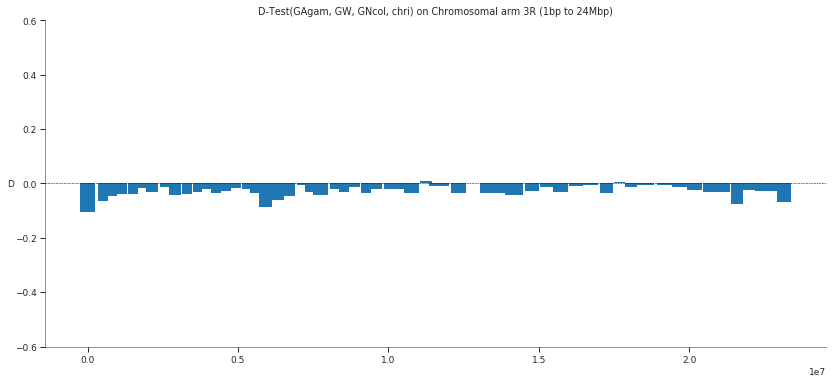

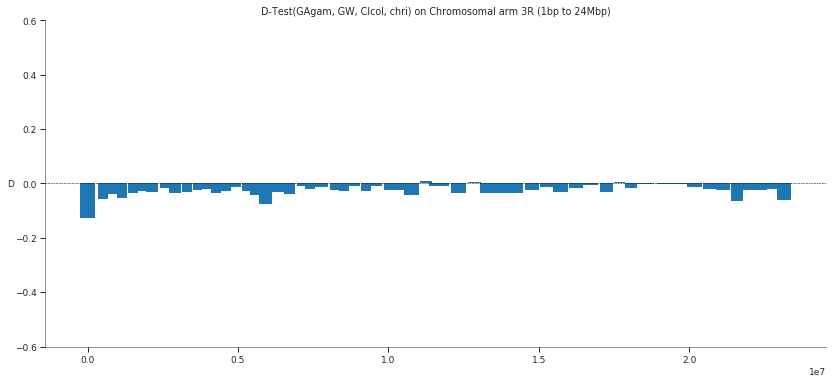

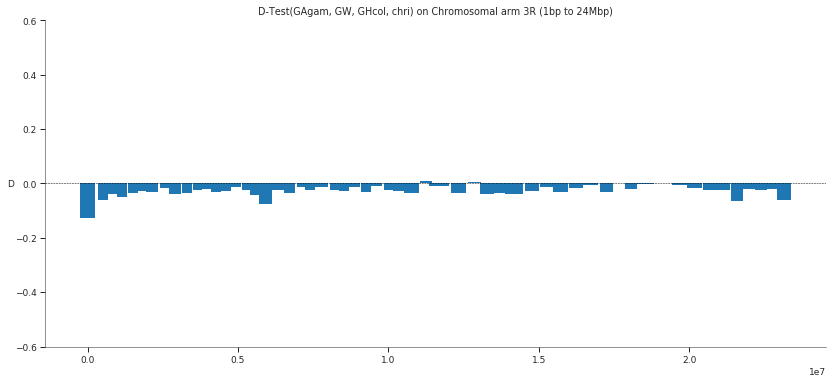

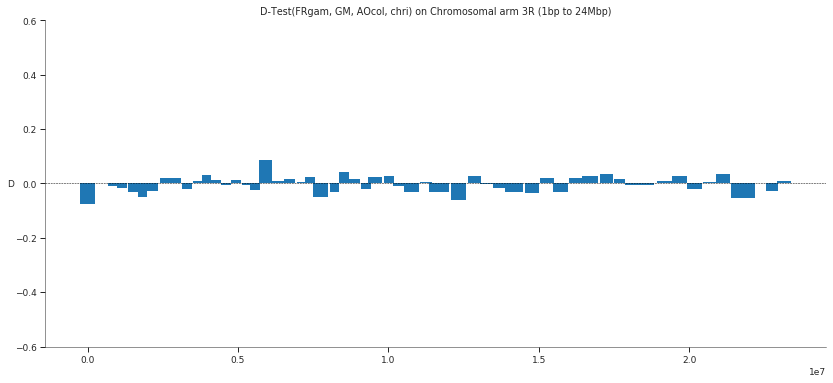

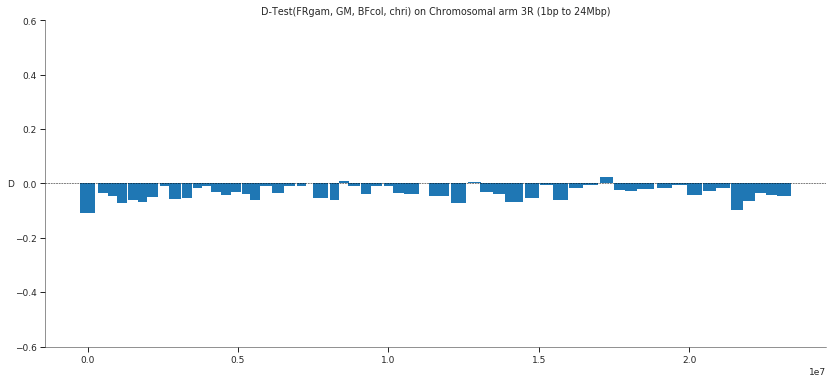

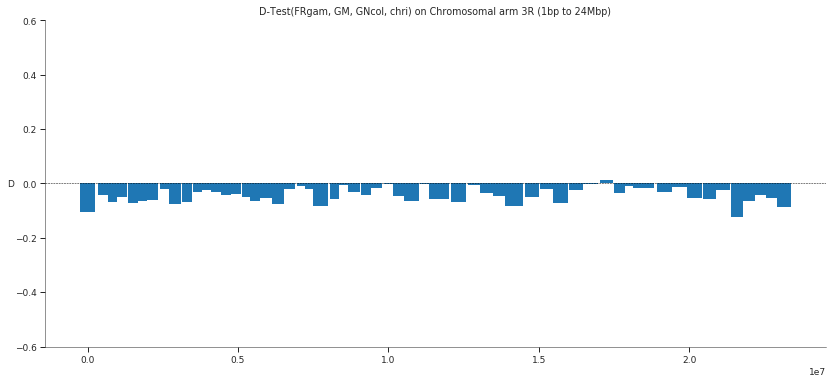

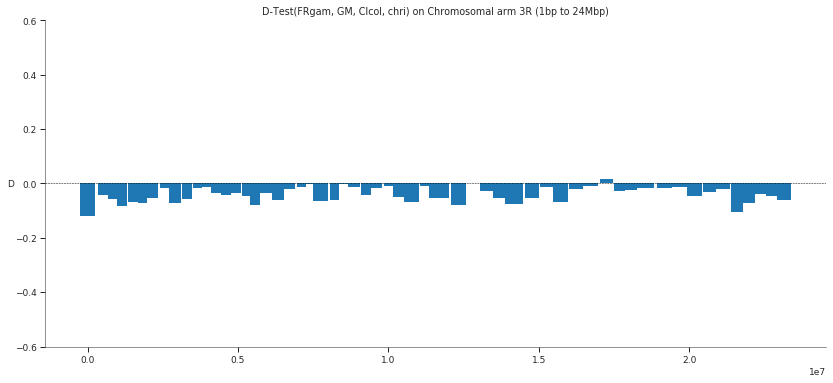

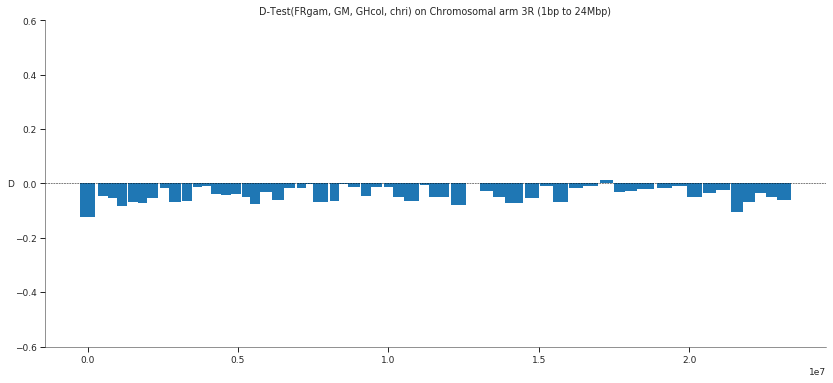

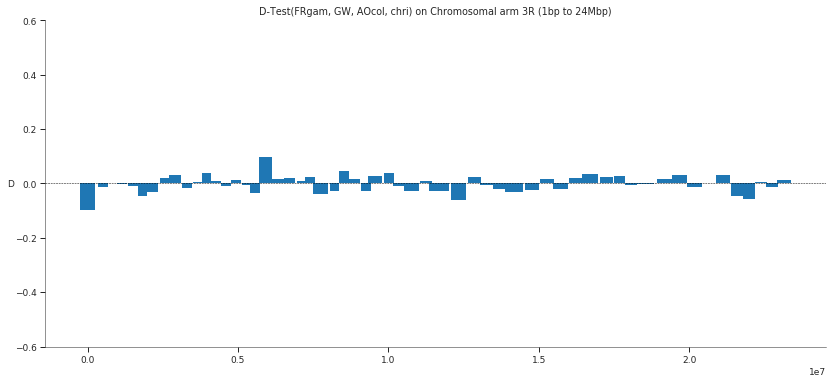

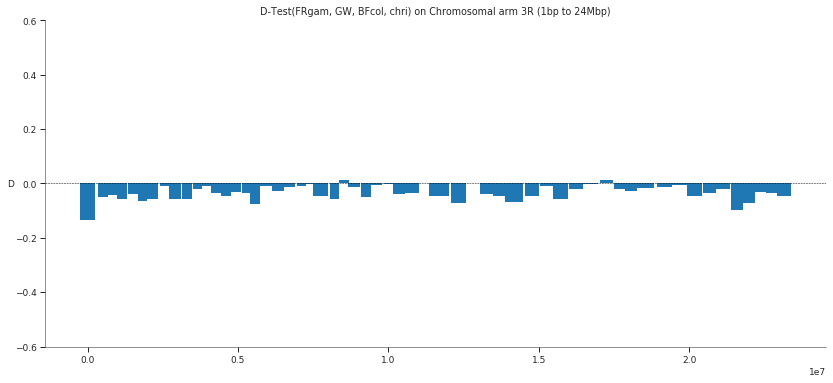

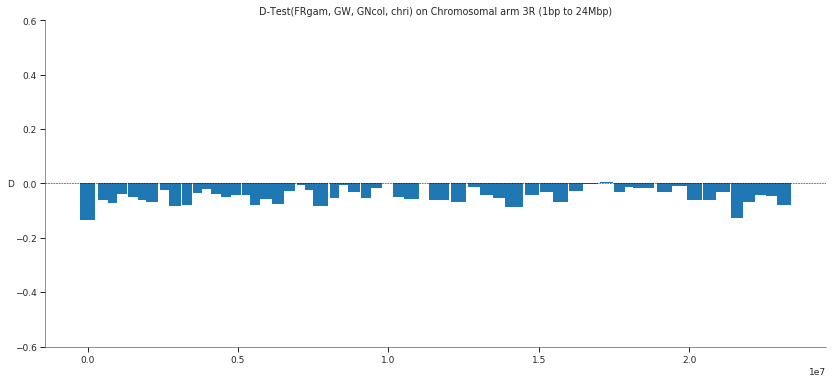

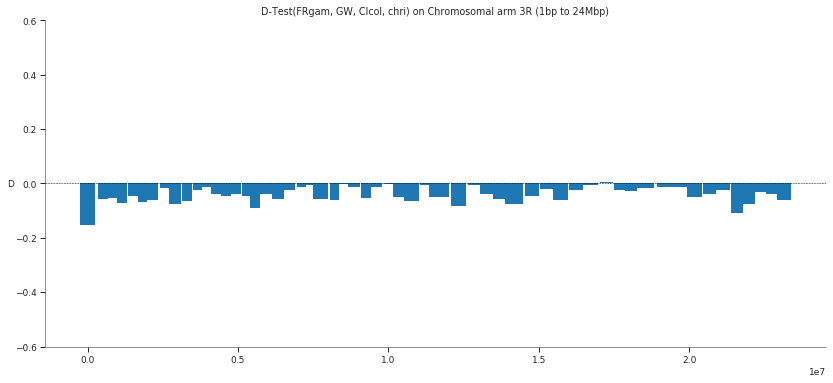

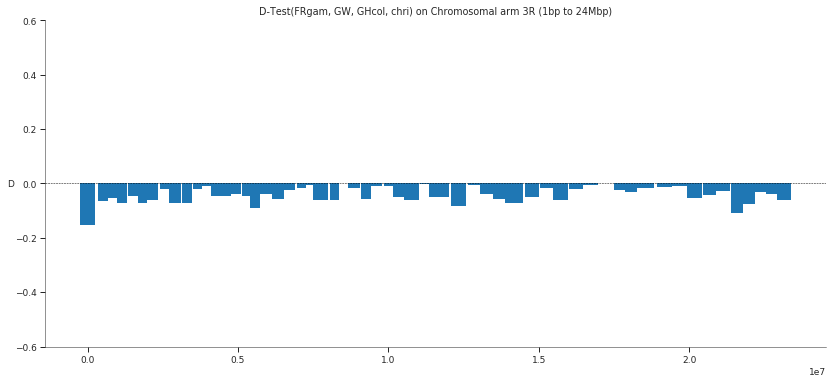

In [27]:
# load variant positions
#title = results_3R['Test']
pos = callset_biallel['3R']['variants']['POS'][loc]
block_starts = allel.moving_statistic(pos, statistic=np.min, size=100000)
block_stops = allel.moving_statistic(pos, statistic=np.max, size=100000)
block_widths = block_stops - block_starts
title = results_3R['Test']
### qui bisogna fare un ciclo:
for i in range(len(bloks_3R)):
    ylim=(-.6, .6)
    fig, ax =  plt.subplots(figsize=(14, 6))
    ax.bar(block_starts, bloks_3R[i], width=block_widths, linewidth=0)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylabel('D', rotation=0, ha='center', va='center')
    ax.set_ylim(*ylim)
    ax.set_title('%s on Chromosomal arm 3R (1bp to 24Mbp)' %(title[i]))
    sns.despine()        
    i+=1